## Imports and Data Loading

In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import umap.umap_ as umap
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from torch.utils.data import Dataset, DataLoader, TensorDataset
from scipy.spatial.distance import cdist

In [2]:
# Load parquet files
ROOT = './'
feats = pd.read_parquet(ROOT + 'data/features.parquet')
lcs = pd.read_parquet(ROOT + 'data/lcs.parquet')
oids = pd.read_parquet(ROOT + 'data/oids.parquet')

## Datasets

In [3]:
# Merge features and oids on 'oid' to create a simple dataset
dataset = pd.merge(oids, feats, on='oid', how='inner')

In [4]:
# Define a simple PyTorch Dataset with the same logic of above
class SimpleFeatureDataset(Dataset):
    def __init__(self, data_path):
        feats = pd.read_parquet(f'{data_path}/features.parquet')
        oids = pd.read_parquet(f'{data_path}/oids.parquet')
        # Merge features and oids on 'oid' (you can select the features you want)
        merged = pd.merge(oids, feats, on='oid', how='inner')
        # Replace NaN with -99 (you can improve this with other strategies)
        self.data = merged.fillna(-99)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data.iloc[idx] # You can convert to tensor if needed

torch_dataset = SimpleFeatureDataset('./data')

## EDA and Visualization

### Shows data and describe

In [5]:
# Print shapes of the loaded data
print(f"Features shape: {feats.shape}")
print(f"Lightcurves shape: {lcs.shape}")
print(f"OIDs shape: {oids.shape}")

print("\n---")

# Show basic info of dataset
print("\nDataset info:")
print(f"Rows: {len(dataset)}, Columns: {len(dataset.columns)}")
# First columns
print(dataset.columns[:5])

print("\n---")

# Show basic info PyTorch dataset
print("\nPyTorch Dataset info:")
print(f"PyTorch Dataset length: {len(torch_dataset)}")
# Example usage
print(torch_dataset[0])

Features shape: (8419, 179)
Lightcurves shape: (5189550, 31)
OIDs shape: (9829, 2)

---

Dataset info:
Rows: 8419, Columns: 180
Index(['oid', 'alerceclass', 'Q31_r', 'Rcs_r', 'Skew_r'], dtype='object')

---

PyTorch Dataset info:
PyTorch Dataset length: 8419
oid                   ZTF18abmrdyx
alerceclass                    CEP
Q31_r                        -99.0
Rcs_r                        -99.0
Skew_r                       -99.0
                          ...     
mean_mag_r                   -99.0
min_mag_r                    -99.0
n_det_r                      -99.0
PercentAmplitude_r           -99.0
Harmonics_mag_5_r            -99.0
Name: 0, Length: 180, dtype: object


In [6]:
feats.head()

,oid,Q31_r,Rcs_r,Skew_r,SmallKurtosis_r,Std_r,StetsonK_r,Pvar_r,ExcessVar_r,PairSlopeTrend_r,...,max_diffmaglim_after_fid_g,median_diffmaglim_after_fid_g,delta_mag_fid_r,delta_mjd_fid_r,first_mag_r,mean_mag_r,min_mag_r,n_det_r,PercentAmplitude_r,Harmonics_mag_5_r
0,ZTF18abmrdyx,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.6052,20.102501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ZTF18abdvyys,0.657821,0.184957,-0.453637,-1.119874,0.347335,0.912642,1.0,0.000661,0.033333,...,20.2962,19.485350,1.063133,1362.247535,13.470280,13.492689,12.974045,22.0,0.048942,0.114427
2,ZTF18abjgfrd,0.241344,0.204626,0.171970,-1.878280,0.119813,0.960020,1.0,0.000053,-0.033333,...,NaN,NaN,0.309963,1362.159144,16.484390,16.323530,16.177994,37.0,0.015189,0.236205
3,ZTF20aaksrbb,0.063570,0.436321,0.481466,-0.290408,0.042348,0.849919,1.0,0.000008,0.100000,...,21.0254,20.326300,0.117467,614.180752,14.485116,14.481151,14.436781,10.0,0.005410,260.767868
4,ZTF18abwqcoy,0.090321,0.237630,1.273315,0.891479,0.341080,0.738760,1.0,0.000303,0.066667,...,21.2738,20.220000,0.893099,797.913345,19.131857,19.246591,19.026735,13.0,0.044680,448.948945


In [7]:
feats.describe()

,Q31_r,Rcs_r,Skew_r,SmallKurtosis_r,Std_r,StetsonK_r,Pvar_r,ExcessVar_r,PairSlopeTrend_r,SF_ML_amplitude_r,...,max_diffmaglim_after_fid_g,median_diffmaglim_after_fid_g,delta_mag_fid_r,delta_mjd_fid_r,first_mag_r,mean_mag_r,min_mag_r,n_det_r,PercentAmplitude_r,Harmonics_mag_5_r
count,7694.000000,7694.000000,7694.000000,7694.000000,7694.000000,7694.000000,7.694000e+03,7694.000000,7694.000000,7694.000000,...,8045.000000,8045.000000,7885.000000,7885.000000,7885.000000,7885.000000,7885.000000,7885.000000,7694.000000,7.885000e+03
mean,0.386163,0.168959,0.047430,0.281581,0.253389,0.814502,9.930798e-01,0.000478,0.004861,0.628818,...,21.190174,20.091485,0.926920,1243.084857,15.423586,15.427888,14.980499,175.867977,0.043515,3.447564e+08
std,0.381601,0.088045,1.052078,4.342269,0.225771,0.112081,7.149802e-02,0.001293,0.140073,1.415894,...,1.257391,0.297043,0.907358,285.026655,1.750585,1.728515,1.779271,161.380534,0.040508,2.735986e+10
min,0.012007,0.033547,-5.128562,-2.056041,0.011614,0.300194,1.785700e-08,-0.000658,-0.833333,-0.500000,...,17.660100,17.645201,0.000000,0.000000,9.794477,11.515887,9.330558,1.000000,0.001334,0.000000e+00
25%,0.171985,0.101212,-0.588088,-1.445527,0.143662,0.743824,1.000000e+00,0.000082,-0.100000,0.210892,...,20.903000,19.957800,0.468344,1184.955764,14.034469,14.048332,13.603972,56.000000,0.022414,1.393093e-02
50%,0.327993,0.145209,-0.044641,-0.870908,0.195420,0.835062,1.000000e+00,0.000158,0.033333,0.297018,...,21.036800,20.151350,0.685512,1346.190937,15.393001,15.361316,14.946087,127.000000,0.031204,3.348942e-02
75%,0.456659,0.219382,0.575249,0.384304,0.277768,0.904644,1.000000e+00,0.000314,0.100000,0.426420,...,21.145100,20.287800,0.998816,1428.123738,16.722733,16.728360,16.331780,252.000000,0.047550,1.492112e-01
max,4.230939,0.495398,9.521461,114.907867,2.211755,0.995508,1.000000e+00,0.019245,0.900000,15.000000,...,59.890701,20.830099,7.916711,1484.118032,21.504791,21.245582,20.548330,1292.000000,0.311038,2.420808e+12


In [8]:
lcs.head()

,oid,tid,mjd,candid,fid,pid,diffmaglim,isdiffpos,nid,distnr,...,drb,magapbig,sigmagapbig,rfid,has_stamp,corrected,dubious,step_id_corr,phase,parent_candid
0,ZTF18aaasdsx,ztf,58534.325521,780325525915010000,2,780325525915,19.043385,-1,780,0.610149,...,0.000000,17.6957,0.1103,1.706120e+09,False,True,False,bulk_1.0.0,0.0,7.862174e+17
1,ZTF18aaasdsx,ztf,58540.217419,786217415915010005,2,786217415915,20.599041,-1,786,0.096748,...,0.000000,18.3134,0.0638,1.706120e+09,True,True,False,bulk_1.0.0,0.0,0.000000e+00
2,ZTF18aaasdsx,ztf,58585.142894,831142895915010001,2,831142895915,19.849493,-1,831,0.081787,...,0.000000,17.8272,0.0752,1.706120e+09,True,True,False,bulk_1.0.0,0.0,0.000000e+00
3,ZTF18aaasdsx,ztf,60539.508808,2785508805915015004,2,2785508805915,18.699131,1,2785,0.642389,...,0.998189,18.1633,0.2563,1.706120e+09,True,True,False,24.5.1,0.0,NaN
4,ZTF18aaasdsx,ztf,60539.509282,2785509285915015003,2,2785509285915,18.652796,1,2785,0.036393,...,0.999355,18.4842,0.3564,1.706120e+09,True,True,False,24.5.1,0.0,NaN


In [9]:
lcs.describe()

,mjd,fid,pid,diffmaglim,isdiffpos,nid,distnr,magpsf,magpsf_corr,magap,...,sigmagap,ra,dec,rb,drb,magapbig,sigmagapbig,rfid,phase,parent_candid
count,5.189550e+06,5.189550e+06,5.189550e+06,5.189550e+06,5.189550e+06,5.189550e+06,5.189550e+06,5.189550e+06,5.154222e+06,5.189550e+06,...,5.189550e+06,5.189550e+06,5.189550e+06,5.189550e+06,3.770253e+06,5.189550e+06,5.189550e+06,3.770253e+06,5189550.0,3.080523e+06
mean,5.936161e+04,1.509215e+00,1.607609e+12,2.008599e+01,-2.713800e-02,1.607286e+03,3.285736e-01,1.726877e+01,1.594597e+01,1.733418e+01,...,7.268280e-02,2.426517e+02,3.737143e+01,7.224959e-01,7.802667e-01,1.731699e+01,8.950740e-02,7.242104e+08,0.0,1.272850e+18
std,6.393632e+02,4.999151e-01,6.393632e+11,6.032817e-01,9.996318e-01,6.393554e+02,2.965118e-01,1.582898e+00,4.383700e+00,1.577486e+00,...,8.779667e-02,1.100680e+02,2.290572e+01,1.750215e-01,3.700571e-01,1.580607e+00,1.105420e-01,6.246142e+09,0.0,5.781291e+17
min,5.824215e+04,1.000000e+00,4.881528e+11,1.032000e+01,-1.000000e+00,4.880000e+02,1.675851e-04,8.220855e+00,9.330558e+00,8.319900e+00,...,5.000000e-04,4.003930e-02,-2.923914e+01,1.285714e-02,0.000000e+00,8.308500e+00,5.000000e-04,2.281201e+08,0.0,0.000000e+00
25%,5.878515e+04,1.000000e+00,1.031149e+12,1.973466e+01,-1.000000e+00,1.031000e+03,1.459190e-01,1.613180e+01,1.446807e+01,1.621130e+01,...,1.610000e-02,2.118162e+02,2.227029e+01,6.071429e-01,7.611415e-01,1.619060e+01,1.810000e-02,5.911203e+08,0.0,9.344296e+17
50%,5.929843e+04,2.000000e+00,1.544433e+12,2.018914e+01,-1.000000e+00,1.544000e+03,2.547770e-01,1.736795e+01,1.576598e+01,1.743210e+01,...,3.910000e-02,2.885772e+02,4.161094e+01,7.542857e-01,9.948432e-01,1.741650e+01,4.650000e-02,7.251202e+08,0.0,1.131454e+18
75%,5.987643e+04,2.000000e+00,2.122434e+12,2.053769e+01,1.000000e+00,2.122000e+03,4.279019e-01,1.850521e+01,1.697913e+01,1.855590e+01,...,9.650000e-02,3.185974e+02,5.576089e+01,8.685714e-01,9.999519e-01,1.854060e+01,1.190000e-01,8.011202e+08,0.0,1.430280e+18
max,6.054451e+04,2.000000e+00,2.790506e+12,2.169945e+01,1.000000e+00,2.790000e+03,1.456330e+01,2.145476e+01,1.000000e+02,2.215920e+01,...,1.473300e+00,3.599351e+02,8.610620e+01,9.914290e-01,1.000000e+00,2.219010e+01,1.786500e+00,1.001872e+12,0.0,2.790501e+18


In [10]:
oids.head()

,oid,alerceclass
index,,
34266,ZTF18abmrdyx,CEP
24912,ZTF18abdvyys,CEP
16221,ZTF18abjgfrd,CEP
26781,ZTF18aaasdsx,CEP
12086,ZTF20aaksrbb,CEP


In [11]:
oids.describe()

,oid,alerceclass
count,9829,9829
unique,9829,5
top,ZTF18abmrdyx,EB
freq,1,3000


In [12]:
# General statistics of the dataset
print(f"Statictics with describe: \n {dataset.describe()}")

Statictics with describe: 
              Q31_r        Rcs_r       Skew_r  SmallKurtosis_r        Std_r  \
count  7694.000000  7694.000000  7694.000000      7694.000000  7694.000000   
mean      0.386163     0.168959     0.047430         0.281581     0.253389   
std       0.381601     0.088045     1.052078         4.342269     0.225771   
min       0.012007     0.033547    -5.128562        -2.056041     0.011614   
25%       0.171985     0.101212    -0.588088        -1.445527     0.143662   
50%       0.327993     0.145209    -0.044641        -0.870908     0.195420   
75%       0.456659     0.219382     0.575249         0.384304     0.277768   
max       4.230939     0.495398     9.521461       114.907867     2.211755   

        StetsonK_r        Pvar_r  ExcessVar_r  PairSlopeTrend_r  \
count  7694.000000  7.694000e+03  7694.000000       7694.000000   
mean      0.814502  9.930798e-01     0.000478          0.004861   
std       0.112081  7.149802e-02     0.001293          0.140073   
m

### Null values and types

In [13]:
print(f"Null values count in the dataset: {dataset.isna().sum().sum()}")

Null values count in the dataset: 131480


In [14]:
print(f"Columns with nulls: {dataset.isna().any().sum()}")

Columns with nulls: 166


In [15]:
pd.set_option("display.max_rows", None) # Show all rows

# Columns with nulls and their counts
null_counts = (
    dataset.isna().sum()
    .reset_index()
    .rename(columns={"index": "column", 0: "nulls"})
    .query("nulls > 0")
    .sort_values(by="nulls", ascending=False)
)

print(f"Columns with nulls and their counts \n {null_counts}")

Columns with nulls and their counts 
                              column  nulls
168            dmag_first_det_fid_g   3500
165    last_diffmaglim_before_fid_g   3500
166           last_mjd_before_fid_g   3500
163     max_diffmaglim_before_fid_g   3500
164  median_diffmaglim_before_fid_g   3500
167              dmag_non_det_fid_g   3500
87     last_diffmaglim_before_fid_r   2893
90             dmag_first_det_fid_r   2893
85      max_diffmaglim_before_fid_r   2893
88            last_mjd_before_fid_r   2893
89               dmag_non_det_fid_r   2893
86   median_diffmaglim_before_fid_r   2893
114                            r-W3   1862
113                            r-W2   1857
112                            g-W3   1743
111                            g-W2   1739
110                           W2-W3   1415
109                           W1-W2   1410
51                 g-r_max_corr_g_r   1064
52                g-r_mean_corr_g_r   1064
59                     MHPS_ratio_r   1018
61              

### Alerceclass distribution

In [16]:
# Analysis of class distribution (alerceclass)
conteo_clase = dataset['alerceclass'].value_counts()

print("Distribution of classes:")
print(conteo_clase)

print("\n---")

print(f"\nNumber of unique classes: {dataset['alerceclass'].nunique()}")

print("\n---")

# Percentage per class
porcentaje_clase = (conteo_clase / len(dataset)) * 100

print("\nPercentage per class:")
print(porcentaje_clase)

Distribution of classes:
alerceclass
EB      2689
RRL     2652
LPV     1374
CEP     1172
DSCT     532
Name: count, dtype: int64

---

Number of unique classes: 5

---

Percentage per class:
alerceclass
EB      31.939660
RRL     31.500178
LPV     16.320228
CEP     13.920893
DSCT     6.319040
Name: count, dtype: float64


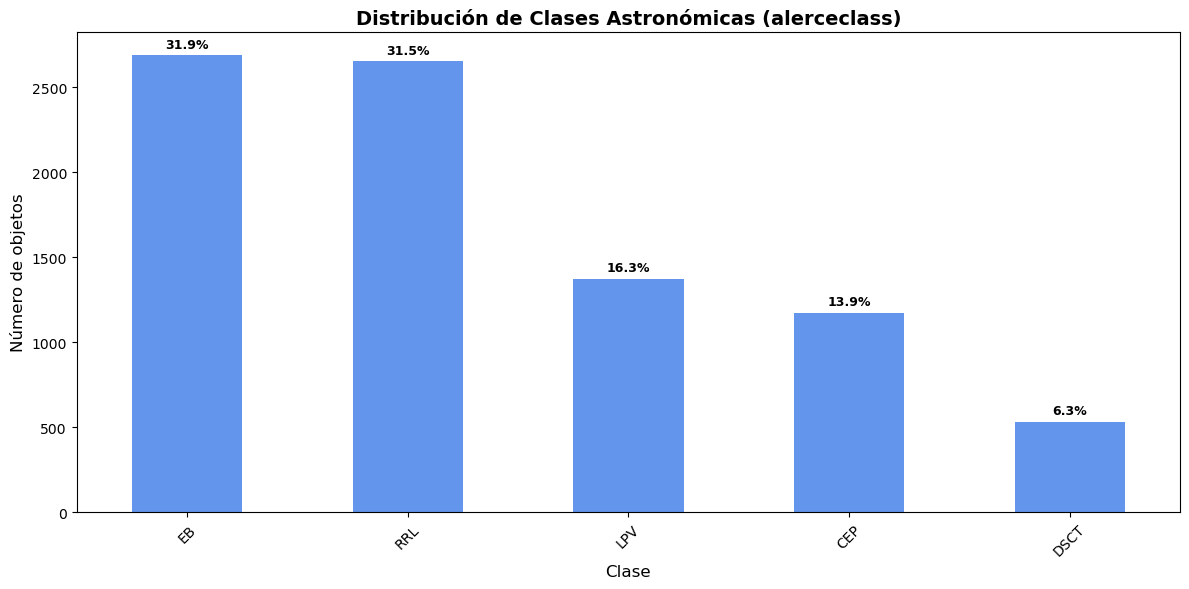

In [17]:
# Visualization - Only the bar chart
plt.figure(figsize=(12, 6))
bars = conteo_clase.plot(kind='bar', color='cornflowerblue')
plt.title('Distribución de Clases Astronómicas (alerceclass)', fontsize=14, fontweight='bold')
plt.xlabel('Clase', fontsize=12)
plt.ylabel('Número de objetos', fontsize=12)
plt.xticks(rotation=45)

# Add percentages on the bars
for i, v in enumerate(conteo_clase):
    porcentaje = porcentaje_clase.iloc[i]
    plt.text(i, v + max(conteo_clase)*0.01, f'{porcentaje:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
plt.tight_layout()
plt.show()

### Features distribution

In [18]:
# Identify numeric columns
numeric_cols = dataset.select_dtypes(include=[np.number]).columns.tolist()

print(f"Numeric features identified: {len(numeric_cols)}")

print("\n---")

print(f"\nName of the 10 first features: {numeric_cols[:10]}")

print("\n---")

desc_stats = dataset[numeric_cols].describe()

# Identify features with high variability
cv = desc_stats.loc['std'] / desc_stats.loc['mean']
high_var_features = cv.sort_values(ascending=False).head(10)
print("\nTop 10 features with greater variability coeficient:")
print(high_var_features)

Numeric features identified: 178

---

Name of the 10 first features: ['Q31_r', 'Rcs_r', 'Skew_r', 'SmallKurtosis_r', 'Std_r', 'StetsonK_r', 'Pvar_r', 'ExcessVar_r', 'PairSlopeTrend_r', 'SF_ML_amplitude_r']

---

Top 10 features with greater variability coeficient:
SmallKurtosis_g      303.156234
GP_DRW_tau_g          87.868224
MHPS_ratio_g          87.426127
Harmonics_mag_7_r     85.608054
Harmonics_mag_6_r     84.466765
Harmonics_mag_3_r     79.831783
Harmonics_mag_5_r     79.359968
Harmonics_mag_2_r     77.554001
Harmonics_mag_4_r     67.143830
Harmonics_mag_1_r     60.752784
dtype: float64


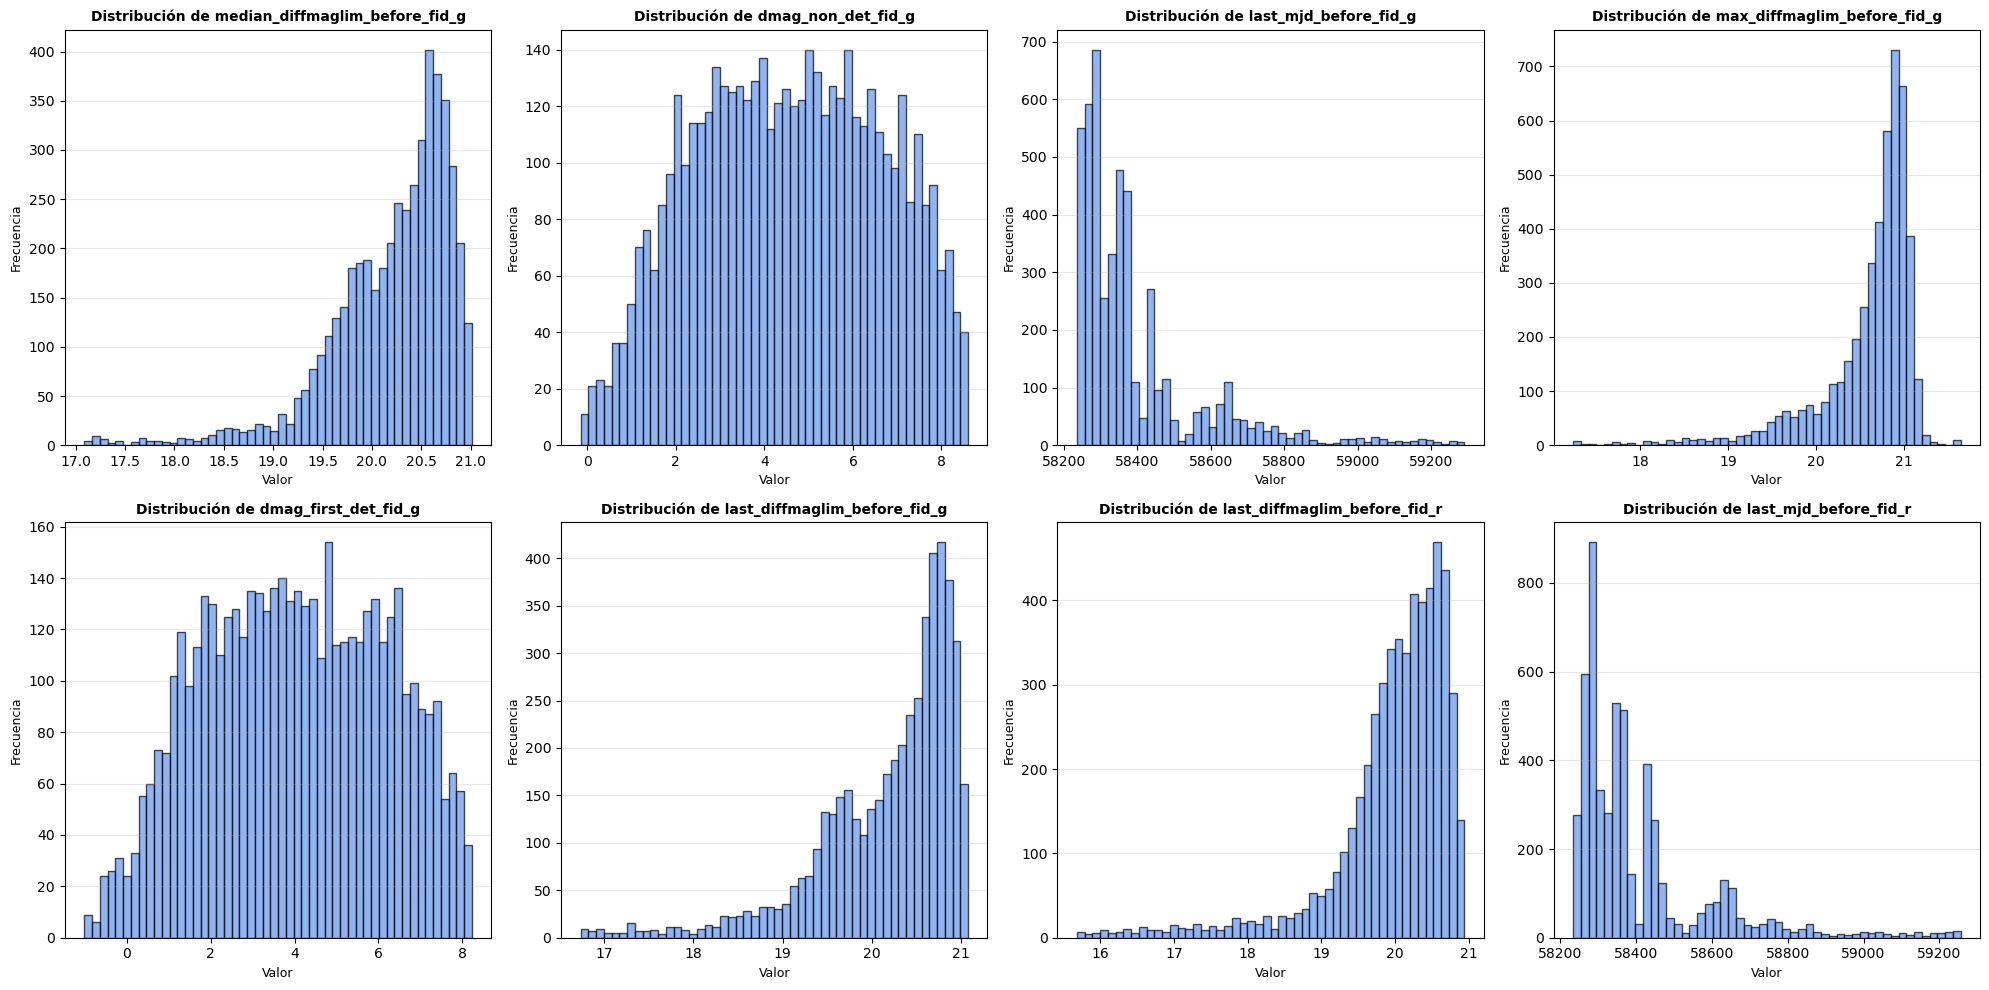

In [19]:
# Visualization of distributions for a sample of features with most nulls
null_counts = dataset[numeric_cols].isnull().sum().sort_values(ascending=False)
sample_features = null_counts.head(8).index.tolist() # Select 8 features with most nulls, can be adjusted

fig, axes = plt.subplots(2, 4, figsize=(20, 10)) # Adjusted to 2x4 for 8 features, can be changed
axes = axes.ravel()

for i, feature in enumerate(sample_features):
    if i < len(axes):
        # Remove extreme outliers for better visualization
        data = dataset[feature].dropna()
        if len(data) > 0:
            q1, q99 = data.quantile([0.01, 0.99])
            filtered_data = data[(data >= q1) & (data <= q99)]

            axes[i].hist(filtered_data, bins=50, alpha=0.7, color='cornflowerblue', edgecolor='black')
            axes[i].set_title(f'Distribución de {feature}', fontsize=10, fontweight='bold')
            axes[i].set_xlabel('Valor', fontsize=9)
            axes[i].set_ylabel('Frecuencia', fontsize=9)
            axes[i].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

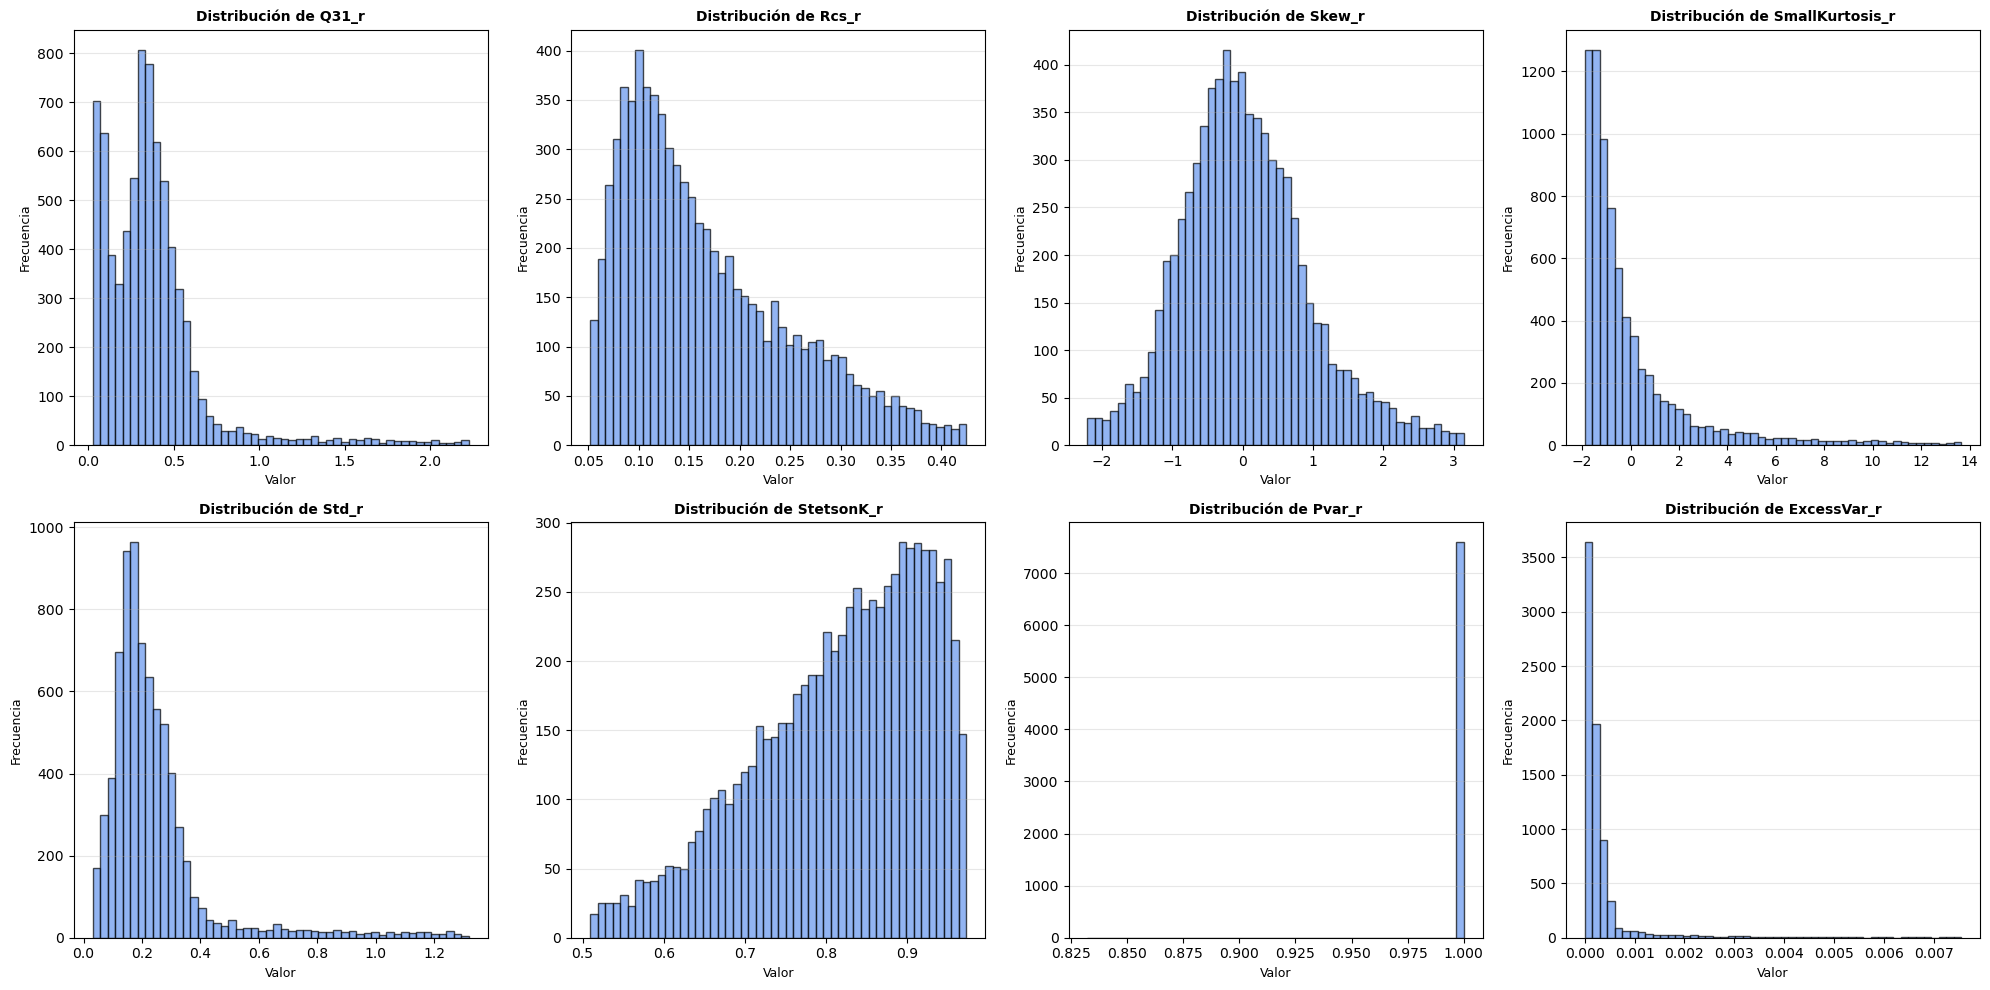

In [20]:
# Visualization of distributions for the first N numeric features
firstN_features = numeric_cols[:8] # Select first 8 features, can be adjusted

fig, axes = plt.subplots(2, 4, figsize=(20, 10)) # Adjusted to 2x4 for 8 features, can be changed
axes = axes.ravel()

for i, feature in enumerate(firstN_features):
    if i < len(axes):
        # Remove extreme outliers for better visualization
        data = dataset[feature].dropna()
        if len(data) > 0:
            q1, q99 = data.quantile([0.01, 0.99])
            filtered_data = data[(data >= q1) & (data <= q99)]

            axes[i].hist(filtered_data, bins=50, alpha=0.7, color='cornflowerblue', edgecolor='black')
            axes[i].set_title(f'Distribución de {feature}', fontsize=10, fontweight='bold')
            axes[i].set_xlabel('Valor', fontsize=9)
            axes[i].set_ylabel('Frecuencia', fontsize=9)
            axes[i].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Astronomical features analysis

In [21]:
# Identify important astronomical features
feature_cols = dataset.columns.tolist()
astro_patterns = ['period', 'freq', 'amplitude', 'phase', 'skew', 'kurt', 'beyond', 'slope', 'color', 'magnitude', 'harmonics', 'spm', 'mhps'] # This list can be adjusted

astro_features = []
for pattern in astro_patterns:
    matches = [col for col in feature_cols if pattern.lower() in col.lower()]
    astro_features.extend(matches)

astro_features = list(set(astro_features))
print(f"Features astronómicos identificados: {len(astro_features)}")
print(f"Ejemplos: {astro_features[:10]}")

Features astronómicos identificados: 75
Ejemplos: ['Gskew_r', 'SPM_t0_r', 'SPM_gamma_g', 'Harmonics_phase_2_r', 'Amplitude_g', 'MHPS_low_r', 'SPM_chi_g', 'Beyond1Std_g', 'Harmonics_mag_3_r', 'SPM_tau_rise_r']


Features de período encontrados: ['delta_period_r', 'Multiband_period_g_r', 'Period_band_g', 'delta_period_g', 'Period_band_r']


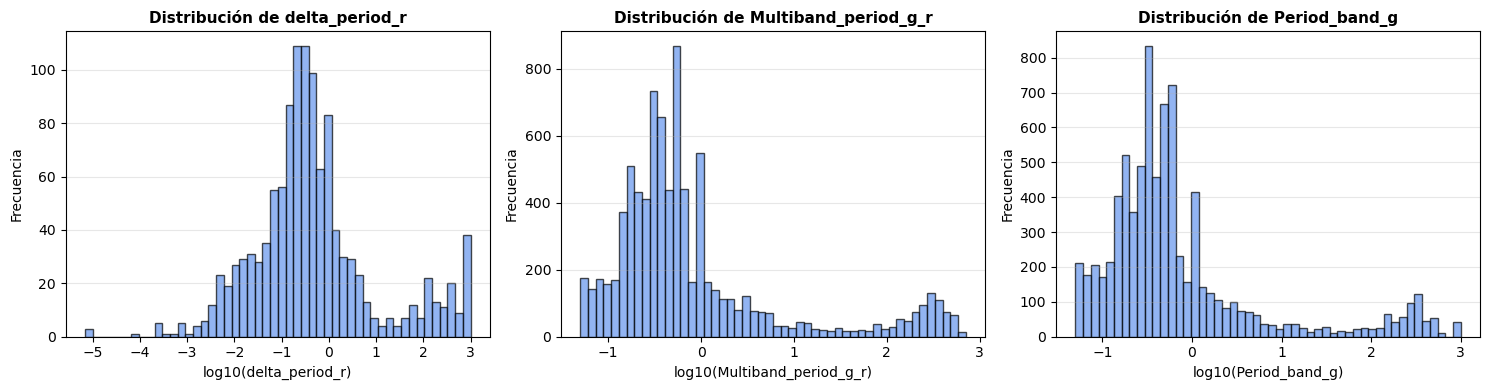

In [22]:
# Analysis of features related to 'period', the same code can be adapted for other patterns
period_features = [col for col in feature_cols if 'period' in col.lower()]
if period_features:
    print(f"Features de período encontrados: {period_features}")

    fig, axes = plt.subplots(1, min(3, len(period_features)), figsize=(15, 4))
    if len(period_features) == 1:
        axes = [axes]

    for i, feature in enumerate(period_features[:3]): # Limit to first 3 for visualization, can be adjusted
        data = dataset[feature].dropna()
        positive_data = data[data > 0]

        if len(positive_data) > 0:
            axes[i].hist(np.log10(positive_data), bins=50, alpha=0.7, color='cornflowerblue', edgecolor='black')
            axes[i].set_xlabel(f'log10({feature})', fontsize=10)
            axes[i].set_ylabel('Frecuencia', fontsize=10)
            axes[i].set_title(f'Distribución de {feature}', fontsize=11, fontweight='bold')
            axes[i].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

### Correlation matrix

In [23]:
# Analysis of correlations, using features with highest variance for clarity
variances = dataset[numeric_cols].var().sort_values(ascending=False)
top_features = variances.head(30).index.tolist() # Using top 30 features with highest variance, can be adjusted
corr_matrix = dataset[top_features].corr()

# Find high correlations
high_corr_pairs = []
correlations = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))
            correlations.append({
            'feature1': corr_matrix.columns[i],
            'feature2': corr_matrix.columns[j],
            'correlation': corr_val})

print(f"Pares de features con |correlación| > 0.8: {len(high_corr_pairs)}")

print("\n---")

print("\nTop 10 correlaciones más altas:")
sorted_pairs = sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True)
for pair in sorted_pairs[:10]:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")

Pares de features con |correlación| > 0.8: 31

---

Top 10 correlaciones más altas:
Harmonics_mag_6_r - Harmonics_mag_7_r: 1.000
Harmonics_mag_3_r - Harmonics_mag_5_r: 0.999
MHPS_non_zero_r - n_det_r: 0.999
Harmonics_mag_2_r - Harmonics_mag_3_r: 0.999
Harmonics_mag_5_r - Harmonics_mag_6_r: 0.999
Harmonics_mag_5_r - Harmonics_mag_7_r: 0.998
Harmonics_mag_3_r - Harmonics_mag_6_r: 0.998
Harmonics_mag_3_r - Harmonics_mag_7_r: 0.997
Harmonics_mag_2_r - Harmonics_mag_5_r: 0.996
Harmonics_mag_2_r - Harmonics_mag_6_r: 0.993


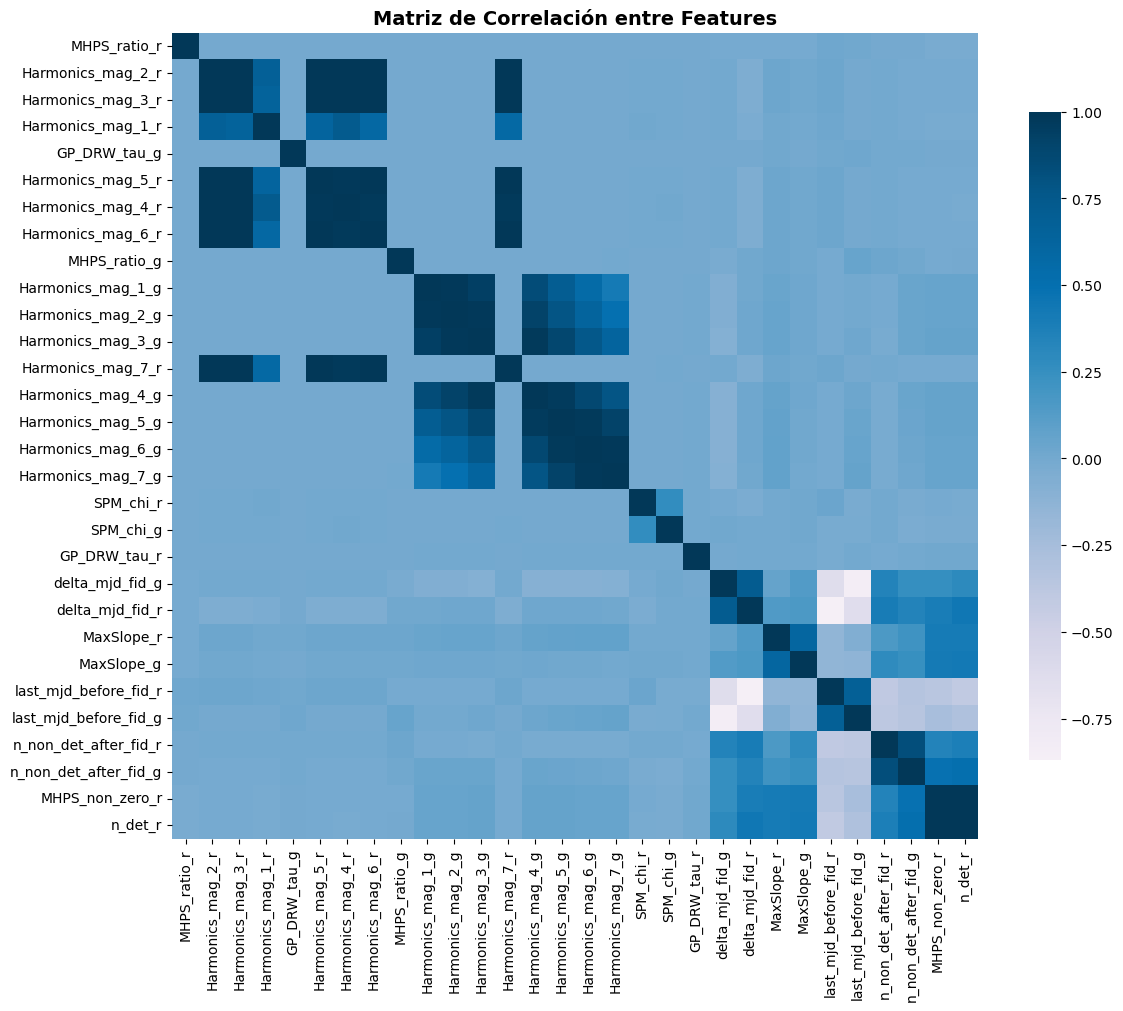

In [24]:
# Visualization of correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='PuBu', center=0, square=True, fmt='.2f', cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación entre Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

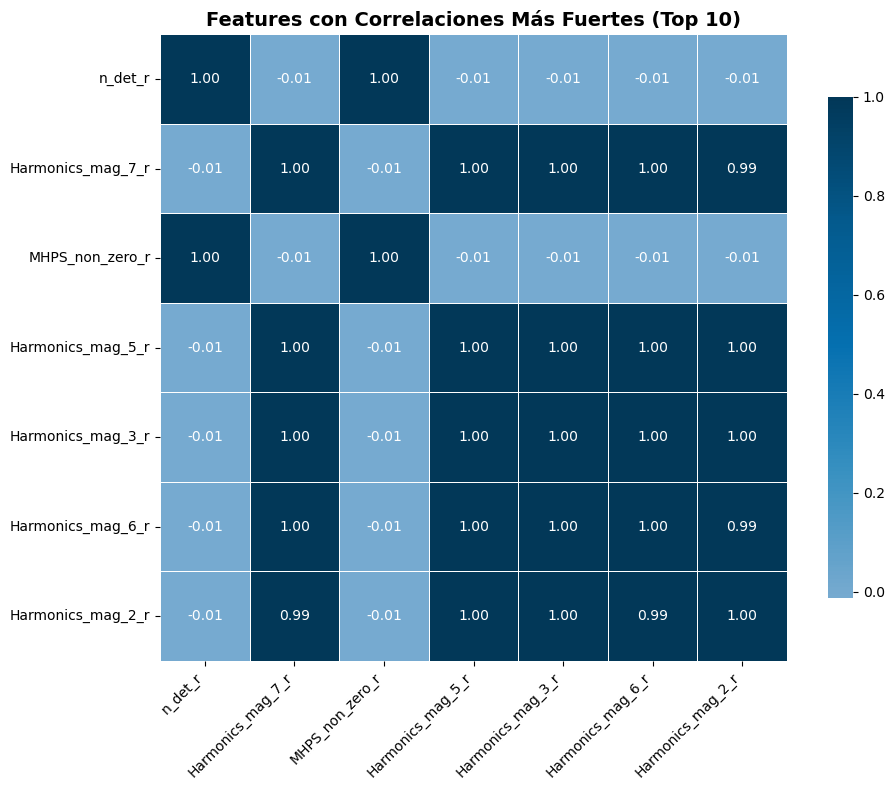

In [25]:
# Visualization of strongest correlations
corr_df = pd.DataFrame(correlations)
corr_df['abs_correlation'] = corr_df['correlation'].abs()
top_correlations = corr_df.nlargest(10, 'abs_correlation') # Top 10 correlations by absolute value, can be adjusted

involved_features = list(set(top_correlations['feature1'].tolist() + top_correlations['feature2'].tolist()))

mini_corr = corr_matrix.loc[involved_features, involved_features]

plt.figure(figsize=(10, 8))
sns.heatmap(mini_corr, annot=True, fmt='.2f', cmap='PuBu', center=0, square=True, cbar_kws={"shrink": 0.8}, linewidths=0.5)
plt.title('Features con Correlaciones Más Fuertes (Top 10)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

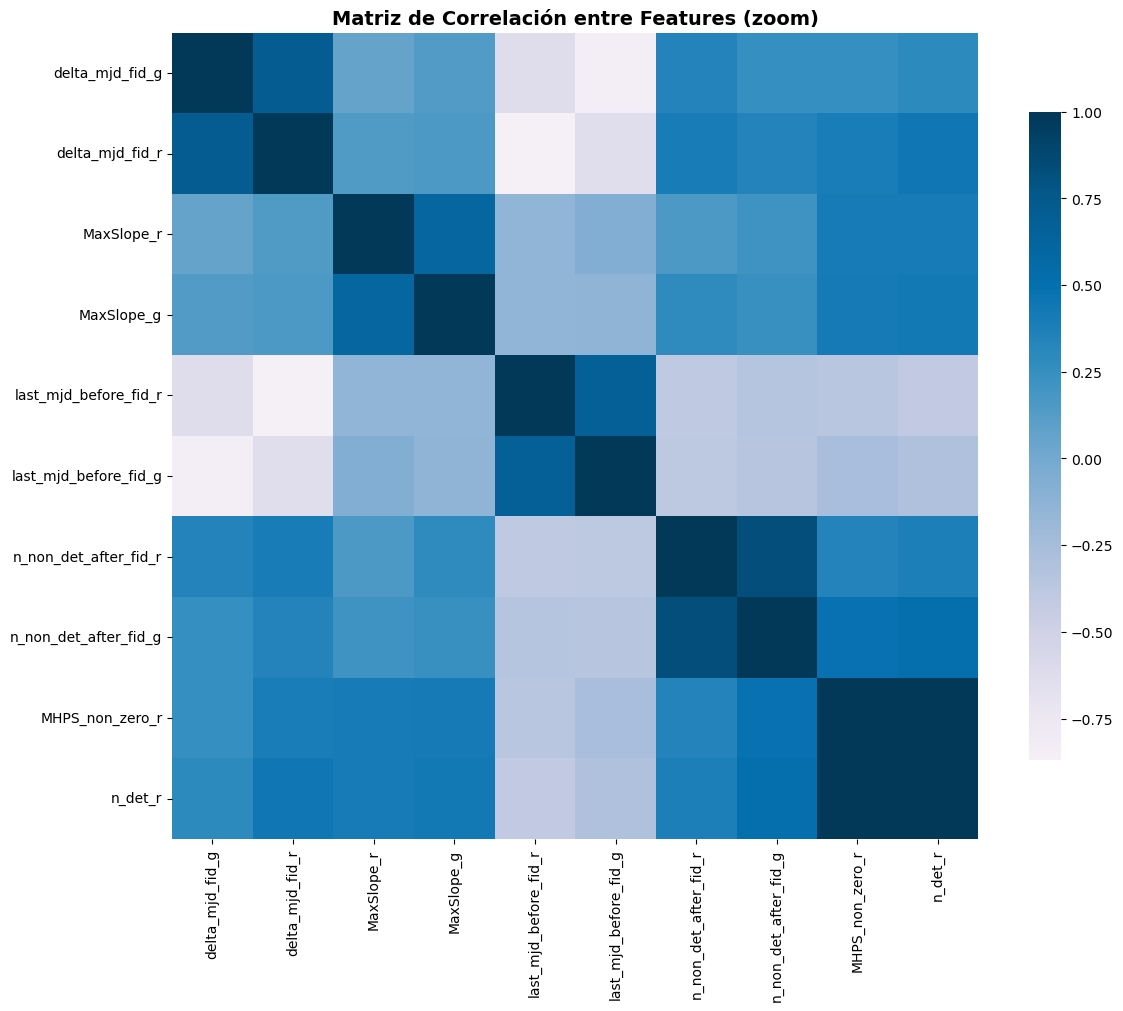

In [26]:
# Zoomed correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix.iloc[20:, 20:], annot=False, cmap='PuBu', center=0, square=True, fmt='.2f', cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación entre Features (zoom)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

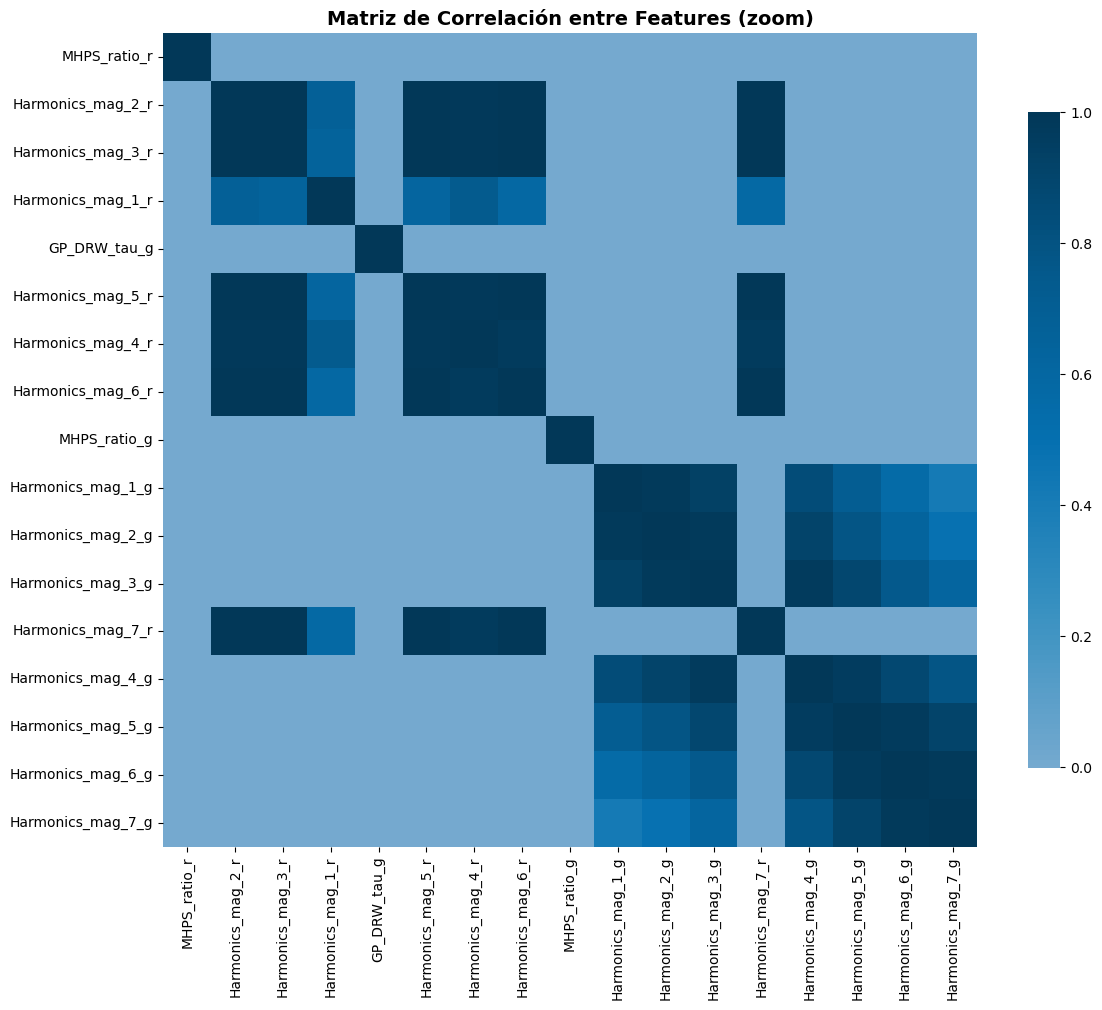

In [27]:
# Zoomed correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix.iloc[:17, :17], annot=False, cmap='PuBu', center=0, square=True, fmt='.2f', cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación entre Features (zoom)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Corner plot

Generate corner plot for: ['Gskew_r', 'SPM_t0_r', 'SPM_gamma_g', 'Harmonics_phase_2_r', 'Amplitude_g']


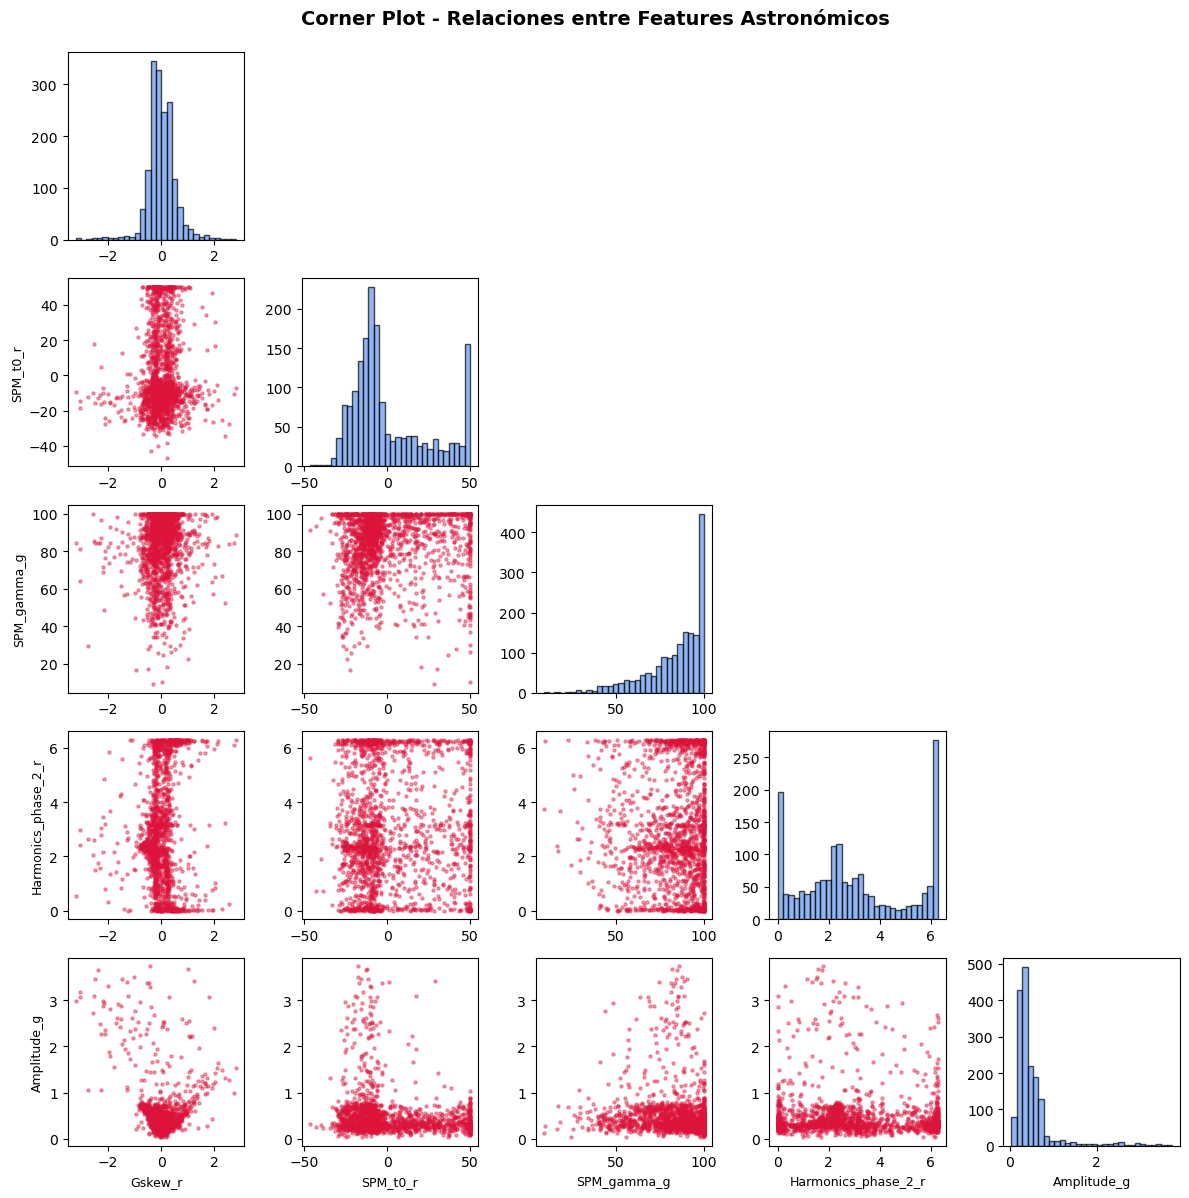

In [28]:
sample_features = astro_features[:5] # Select a few astronomical features for corner plot, can be adjusted
print(f"Generate corner plot for: {sample_features}")
sample_data = dataset.sample(n=2000, random_state=42)

plot_data = sample_data[sample_features].dropna()

fig, axes = plt.subplots(len(sample_features), len(sample_features), figsize=(12, 12))

for i, feat1 in enumerate(sample_features):
    for j, feat2 in enumerate(sample_features):
        ax = axes[i, j]

        if i == j: # Diagonal - histograms
            data = plot_data[feat1]
            ax.hist(data, bins=30, alpha=0.7, color='cornflowerblue', edgecolor='black')
            if i == len(sample_features) - 1:
                ax.set_xlabel(feat1, fontsize=9)

        elif i > j: # Inferior triangle - scatter plots
            x_data = plot_data[feat2]
            y_data = plot_data[feat1]
            ax.scatter(x_data, y_data, alpha=0.4, s=5, color='crimson')
            if j == 0:
                ax.set_ylabel(feat1, fontsize=9)
            if i == len(sample_features) - 1:
                ax.set_xlabel(feat2, fontsize=9)

        else: # Superior triangle - empty
            ax.axis('off')

plt.suptitle('Corner Plot - Relaciones entre Features Astronómicos', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

### PCA, UMAP and t-SNE

In [29]:
# Parameters for data preparation
max_features = 178
handle_missing = 'drop' # Options: 'drop', 'fill', 'median'

# Manejar valores faltantes
if handle_missing == 'drop':
    clean_data = dataset[numeric_cols].dropna()
    print(f"Lenght data after eliminate NaN: {len(clean_data)} objects")
    if 'alerceclass' in dataset.columns:
        labels = dataset.loc[clean_data.index, 'alerceclass'].values
elif handle_missing == 'fill':
    clean_data = dataset[numeric_cols].fillna(-99)
    print(f"NaN values filled with -99")
    labels = dataset['alerceclass'].values if 'alerceclass' in dataset.columns else None
else: # median
    clean_data = dataset[numeric_cols].fillna(dataset[numeric_cols].median())
    print(f"NaN values filled with median")
    labels = dataset['alerceclass'].values if 'alerceclass' in dataset.columns else None

# Select subset of features if there are too many, based on variance
if len(numeric_cols) > max_features:
    variances = clean_data.var().sort_values(ascending=False)
    selected_features = variances.head(max_features).index.tolist()
    clean_data = clean_data[selected_features]
    print(f"Selected {max_features} features with greater variance")
else:
    selected_features = numeric_cols

print("\n---")

print(f"\nFeatures finales seleccionadas: {len(selected_features)}")

print("\n---")

# Normalized data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(clean_data)
print(f"\nNormalized data: shape {normalized_data.shape}")

Lenght data after eliminate NaN: 2367 objects

---

Features finales seleccionadas: 178

---

Normalized data: shape (2367, 178)


Using PCA...
Using UMAP...


/home/vixo/miniforge3/envs/projectCI/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Using TSNE...


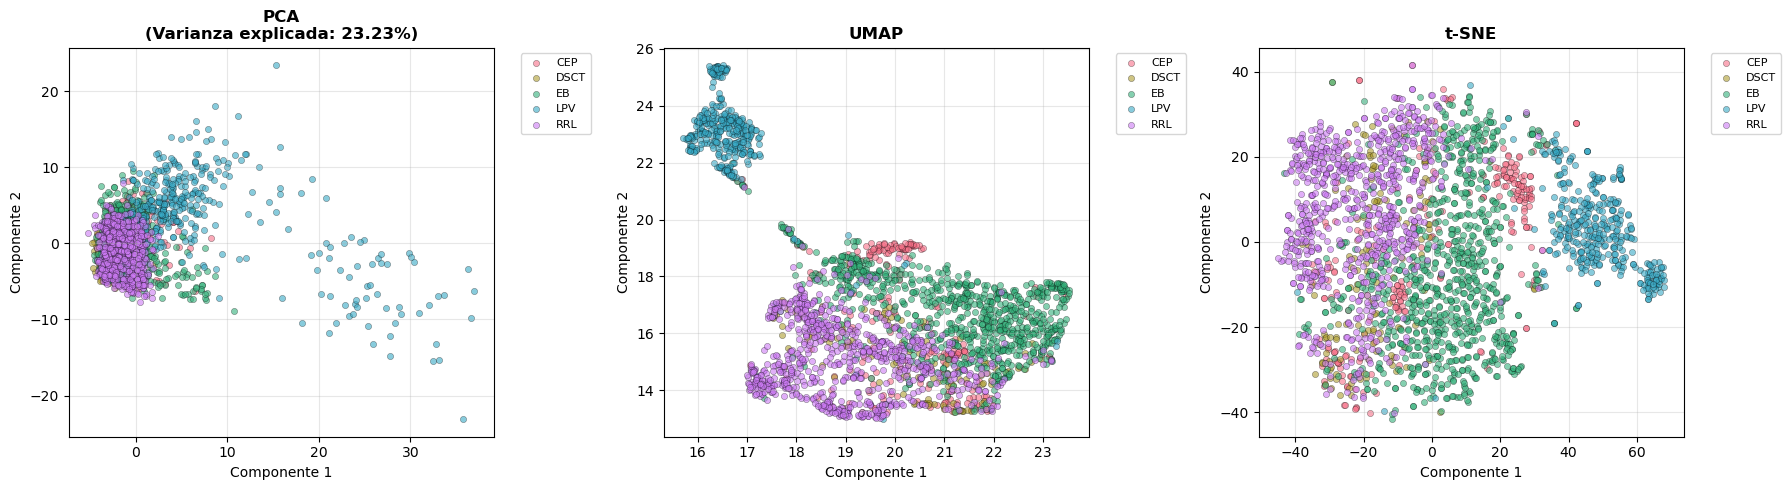

In [30]:
methods = ['PCA', 'UMAP', 'TSNE']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, method in enumerate(methods):
    print(f"Using {method}...")

    if method == 'PCA':
        reducer = PCA(n_components=2, random_state=42)
        embedding = reducer.fit_transform(normalized_data)
        explained_var = reducer.explained_variance_ratio_
        title = f'PCA\n(Varianza explicada: {explained_var.sum():.2%})'

    elif method == 'UMAP':
        reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
        embedding = reducer.fit_transform(normalized_data)
        title = 'UMAP'

    elif method == 'TSNE':
        # For t-SNE, use a sample if there are too many data points
        if len(normalized_data) > 5000:
            sample_idx = np.random.choice(len(normalized_data), 5000, replace=False)
            data_sample = normalized_data[sample_idx]
            labels_sample = labels[sample_idx] if labels is not None else None
        else:
            data_sample = normalized_data
            labels_sample = labels

        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
        embedding = reducer.fit_transform(data_sample)
        title = 't-SNE'

    # Plotting
    if labels is not None:
        plot_labels = labels_sample if method == 'TSNE' else labels
        unique_labels = np.unique(plot_labels)

        # USe just the top 10 classes for readability
        if len(unique_labels) > 10:
            top_classes = class_counts.head(10).index
            mask_top = np.isin(plot_labels, top_classes)
            embedding_plot = embedding[mask_top]
            labels_plot = plot_labels[mask_top]
        else:
            embedding_plot = embedding
            labels_plot = plot_labels

        unique_labels_plot = np.unique(labels_plot)
        #colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels_plot)))
        colors = sns.color_palette("husl", len(unique_labels_plot))

        for label, color in zip(unique_labels_plot, colors):
            mask = labels_plot == label
            axes[i].scatter(embedding_plot[mask, 0], embedding_plot[mask, 1], c=[color], label=label, alpha=0.6, s=20, edgecolors='black', linewidth=0.3)

        axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    else:
        axes[i].scatter(embedding[:, 0], embedding[:, 1], alpha=0.6, s=20, c='blue', edgecolors='black', linewidth=0.3)

    axes[i].set_title(title, fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Componente 1', fontsize=10)
    axes[i].set_ylabel('Componente 2', fontsize=10)
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Autoencoder

In [38]:
print("="*80)
print("PARTE 0: SELECCIÓN DE FEATURES CON RANDOM FOREST")
print("="*80)

# Configurar si quieres usar Random Forest para seleccionar features
USE_RF_SELECTION = False
N_IMPORTANT_FEATURES = 50  # Número de features a seleccionar

if USE_RF_SELECTION and labels is not None:
    print("\nEntrenando Random Forest para importancia de features...")
    
    # Entrenar RF con una muestra si hay muchos datos
    if len(clean_data) > 10000:
        sample_idx = np.random.choice(len(clean_data), 10000, replace=False)
        X_sample = normalized_data[sample_idx]
        y_sample = labels[sample_idx]
    else:
        X_sample = normalized_data
        y_sample = labels
    
    # Entrenar Random Forest
    rf = RandomForestClassifier(n_estimators=100, max_depth=10, 
                                random_state=42, n_jobs=-1)
    rf.fit(X_sample, y_sample)
    
    # Obtener importancia de features
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 10 features más importantes:")
    print(feature_importance.head(10))
    
    # Seleccionar top N features
    top_features = feature_importance.head(N_IMPORTANT_FEATURES)['feature'].tolist()
    
    # Obtener índices de las features seleccionadas
    feature_indices = [selected_features.index(f) for f in top_features]
    selected_data = normalized_data[:, feature_indices]
    
    print(f"\nDatos reducidos a {N_IMPORTANT_FEATURES} features más importantes")
    print(f"Shape: {selected_data.shape}")
    
    # Visualizar importancia
    plt.figure(figsize=(12, 6))
    plt.bar(range(20), feature_importance.head(20)['importance'])
    plt.xticks(range(20), feature_importance.head(20)['feature'], rotation=45, ha='right')
    plt.xlabel('Feature')
    plt.ylabel('Importancia')
    plt.title('Top 20 Features Más Importantes (Random Forest)')
    plt.tight_layout()
    plt.show()
else:
    selected_data = normalized_data
    print("\nUsando todos los features sin selección RF")

PARTE 0: SELECCIÓN DE FEATURES CON RANDOM FOREST

Usando todos los features sin selección RF



PARTE 1: AUTOENCODER CON PYTORCH

Modelo Autoencoder creado:
  - Input dimension: 178
  - Latent dimension: 2
  - Device: cpu

Arquitectura del Encoder:
Sequential(
  (0): Linear(in_features=178, out_features=89, bias=True)
  (1): BatchNorm1d(89, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=89, out_features=44, bias=True)
  (5): BatchNorm1d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.2, inplace=False)
  (8): Linear(in_features=44, out_features=2, bias=True)
)

Arquitectura del Decoder:
Sequential(
  (0): Linear(in_features=2, out_features=44, bias=True)
  (1): BatchNorm1d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.2, inplace=False)
  (4): Linear(in_features=44, out_features=89, bias=True)
  (5): BatchNorm1d(89, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (

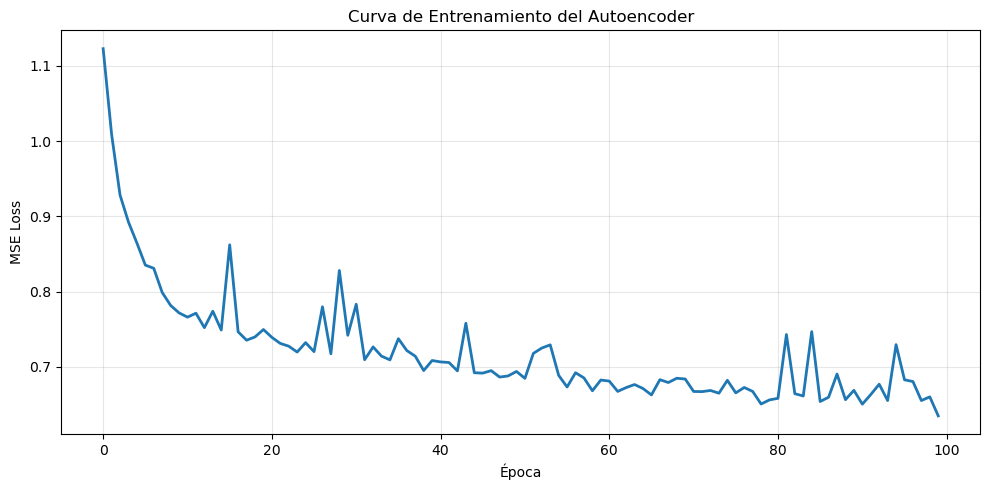


Representación latente obtenida: (2367, 2)


In [39]:
print("\n" + "="*80)
print("PARTE 1: AUTOENCODER CON PYTORCH")
print("="*80)

# Definir arquitectura del Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=2):
        super(Autoencoder, self).__init__()
        
        # Dimensiones intermedias
        hidden_dim1 = input_dim // 2
        hidden_dim2 = max(input_dim // 4, latent_dim * 4)
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.BatchNorm1d(hidden_dim1),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.BatchNorm1d(hidden_dim2),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(hidden_dim2, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim2),
            nn.BatchNorm1d(hidden_dim2),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.BatchNorm1d(hidden_dim1),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(hidden_dim1, input_dim)
        )
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        z = self.encode(x)
        x_reconstructed = self.decode(z)
        return x_reconstructed, z

# Parámetros del modelo
LATENT_DIM = 2  # Dimensión del cuello de botella (puedes cambiar a 3, 4, etc.)
BATCH_SIZE = 256
EPOCHS = 100
LEARNING_RATE = 0.001

# Preparar datos para PyTorch
X_tensor = torch.FloatTensor(selected_data)
dataset_ae = TensorDataset(X_tensor)
dataloader = DataLoader(dataset_ae, batch_size=BATCH_SIZE, shuffle=True)

# Crear modelo
input_dim = selected_data.shape[1]
model = Autoencoder(input_dim=input_dim, latent_dim=LATENT_DIM)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"\nModelo Autoencoder creado:")
print(f"  - Input dimension: {input_dim}")
print(f"  - Latent dimension: {LATENT_DIM}")
print(f"  - Device: {device}")
print(f"\nArquitectura del Encoder:")
print(model.encoder)
print(f"\nArquitectura del Decoder:")
print(model.decoder)

# Loss y optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Entrenamiento
print(f"\nIniciando entrenamiento por {EPOCHS} épocas...")
train_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    
    for batch_idx, (data,) in enumerate(dataloader):
        data = data.to(device)
        
        # Forward pass
        reconstructed, latent = model(data)
        loss = criterion(reconstructed, data)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(dataloader)
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Época [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.6f}")

print("\n¡Entrenamiento completado!")

# Visualizar curva de entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(train_losses, linewidth=2)
plt.xlabel('Época')
plt.ylabel('MSE Loss')
plt.title('Curva de Entrenamiento del Autoencoder')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Obtener representación latente
model.eval()
with torch.no_grad():
    X_tensor_full = torch.FloatTensor(selected_data).to(device)
    reconstructed, latent_representation = model(X_tensor_full)
    latent_np = latent_representation.cpu().numpy()

print(f"\nRepresentación latente obtenida: {latent_np.shape}")


Visualizando espacio latente del Autoencoder...


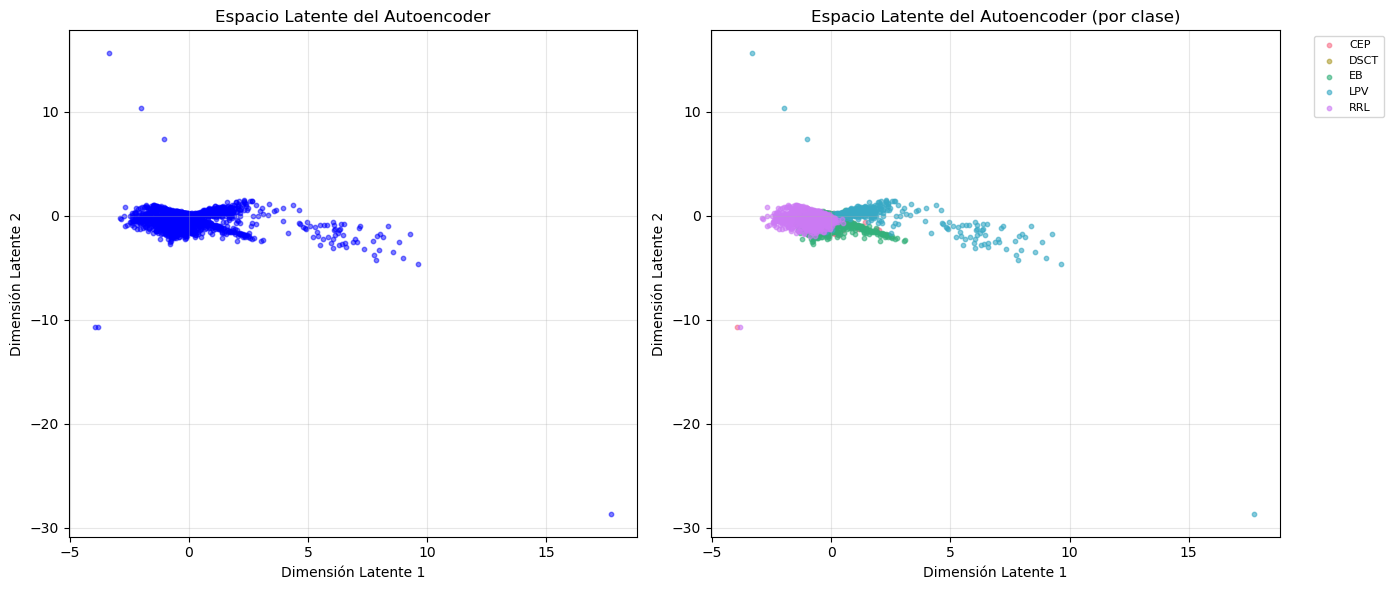

In [40]:
print("\nVisualizando espacio latente del Autoencoder...")

if LATENT_DIM == 2:
    # Visualización 2D
    plt.figure(figsize=(14, 6))
    
    # Sin etiquetas
    plt.subplot(1, 2, 1)
    plt.scatter(latent_np[:, 0], latent_np[:, 1], alpha=0.5, s=10, c='blue')
    plt.xlabel('Dimensión Latente 1')
    plt.ylabel('Dimensión Latente 2')
    plt.title('Espacio Latente del Autoencoder')
    plt.grid(alpha=0.3)
    
    # Con etiquetas (si existen)
    if labels is not None:
        plt.subplot(1, 2, 2)
        unique_labels_plot = np.unique(labels)
        colors = sns.color_palette("husl", len(unique_labels_plot))
        
        for label, color in zip(unique_labels_plot, colors):
            mask = labels == label
            plt.scatter(latent_np[mask, 0], latent_np[mask, 1], 
                       c=[color], label=label, alpha=0.6, s=10)
        
        plt.xlabel('Dimensión Latente 1')
        plt.ylabel('Dimensión Latente 2')
        plt.title('Espacio Latente del Autoencoder (por clase)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

elif LATENT_DIM >= 3:
    # Visualización 3D para las primeras 3 dimensiones
    from mpl_toolkits.mplot3d import Axes3D
    
    fig = plt.figure(figsize=(14, 6))
    
    # Sin etiquetas
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(latent_np[:, 0], latent_np[:, 1], latent_np[:, 2], 
               alpha=0.5, s=10, c='blue')
    ax1.set_xlabel('Dim 1')
    ax1.set_ylabel('Dim 2')
    ax1.set_zlabel('Dim 3')
    ax1.set_title('Espacio Latente 3D del Autoencoder')
    
    # Con etiquetas
    if labels is not None:
        ax2 = fig.add_subplot(122, projection='3d')
        unique_labels_plot = np.unique(labels)
        colors = sns.color_palette("husl", len(unique_labels_plot))
        
        for label, color in zip(unique_labels_plot, colors):
            mask = labels == label
            ax2.scatter(latent_np[mask, 0], latent_np[mask, 1], latent_np[mask, 2],
                       c=[color], label=label, alpha=0.6, s=10)
        
        ax2.set_xlabel('Dim 1')
        ax2.set_ylabel('Dim 2')
        ax2.set_zlabel('Dim 3')
        ax2.set_title('Espacio Latente 3D (por clase)')
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    
    plt.tight_layout()
    plt.show()


PARTE 2: CLUSTERING CON GAUSSIAN MIXTURE MODEL (GMM)

Buscando número óptimo de clusters...
  n_components=2: BIC=12097.97, AIC=12034.51, Silhouette=0.726
  n_components=3: BIC=11824.88, AIC=11726.80, Silhouette=0.502
  n_components=4: BIC=11610.84, AIC=11478.15, Silhouette=0.317
  n_components=5: BIC=10965.84, AIC=10798.53, Silhouette=0.296
  n_components=6: BIC=10874.39, AIC=10672.46, Silhouette=0.270
  n_components=7: BIC=10725.72, AIC=10489.18, Silhouette=0.293
  n_components=8: BIC=10720.35, AIC=10449.19, Silhouette=0.283
  n_components=9: BIC=10705.17, AIC=10399.40, Silhouette=0.334
  n_components=10: BIC=10679.52, AIC=10339.12, Silhouette=0.327
  n_components=11: BIC=10679.29, AIC=10304.28, Silhouette=0.216
  n_components=12: BIC=10667.47, AIC=10257.84, Silhouette=0.261
  n_components=13: BIC=10681.12, AIC=10236.88, Silhouette=0.359
  n_components=14: BIC=10693.07, AIC=10214.21, Silhouette=0.335


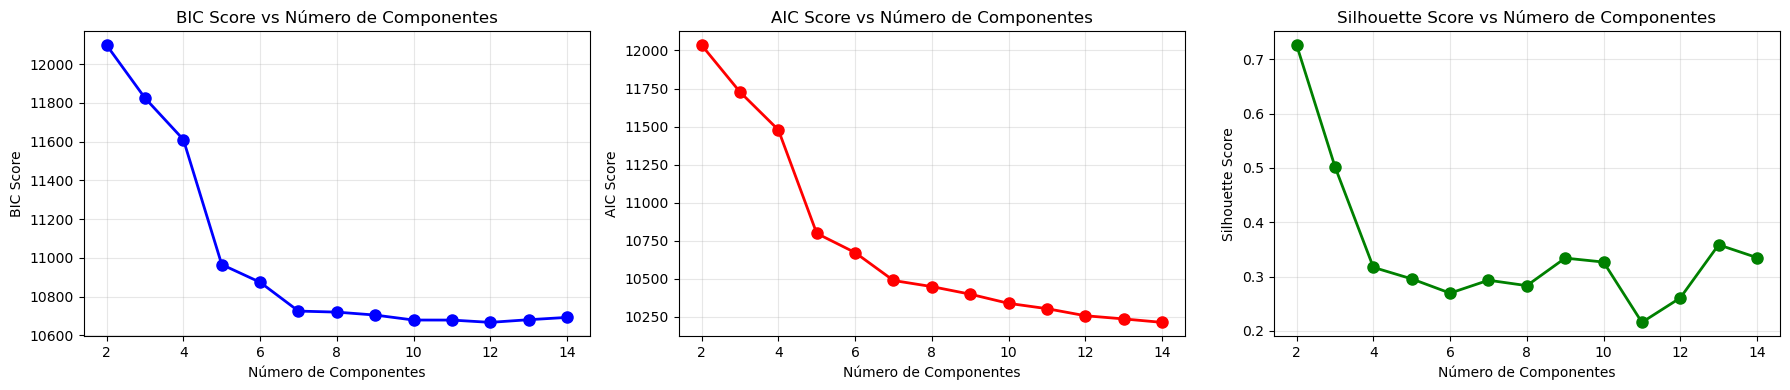


Número óptimo de componentes según BIC: 12

Entrenando GMM con 12 componentes...

Distribución de clusters GMM:
  Cluster 0: 156 objetos (6.6%)
  Cluster 1: 296 objetos (12.5%)
  Cluster 2: 435 objetos (18.4%)
  Cluster 3: 1 objetos (0.0%)
  Cluster 4: 57 objetos (2.4%)
  Cluster 5: 108 objetos (4.6%)
  Cluster 6: 115 objetos (4.9%)
  Cluster 7: 3 objetos (0.1%)
  Cluster 8: 367 objetos (15.5%)
  Cluster 9: 46 objetos (1.9%)
  Cluster 10: 2 objetos (0.1%)
  Cluster 11: 781 objetos (33.0%)


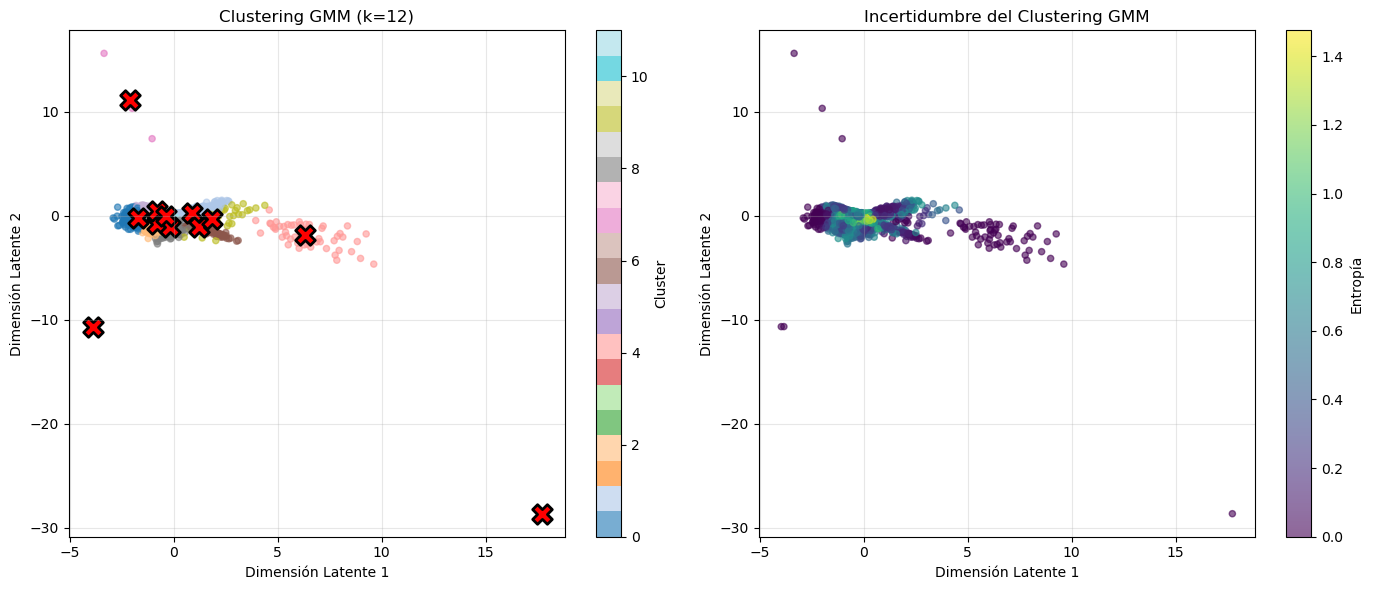

In [41]:
print("\n" + "="*80)
print("PARTE 2: CLUSTERING CON GAUSSIAN MIXTURE MODEL (GMM)")
print("="*80)

# Parámetros del GMM
N_COMPONENTS_RANGE = range(2, 15)  # Probar diferentes números de clusters

# Buscar número óptimo de componentes
bic_scores = []
aic_scores = []
silhouette_scores = []

print("\nBuscando número óptimo de clusters...")
for n_components in N_COMPONENTS_RANGE:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full',
                         random_state=42, n_init=10)
    gmm.fit(latent_np)
    
    bic_scores.append(gmm.bic(latent_np))
    aic_scores.append(gmm.aic(latent_np))
    
    cluster_labels = gmm.predict(latent_np)
    if len(np.unique(cluster_labels)) > 1:
        sil_score = silhouette_score(latent_np, cluster_labels)
        silhouette_scores.append(sil_score)
    else:
        silhouette_scores.append(0)
    
    print(f"  n_components={n_components}: BIC={bic_scores[-1]:.2f}, "
          f"AIC={aic_scores[-1]:.2f}, Silhouette={silhouette_scores[-1]:.3f}")

# Visualizar métricas
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

axes[0].plot(N_COMPONENTS_RANGE, bic_scores, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Número de Componentes')
axes[0].set_ylabel('BIC Score')
axes[0].set_title('BIC Score vs Número de Componentes')
axes[0].grid(alpha=0.3)

axes[1].plot(N_COMPONENTS_RANGE, aic_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Número de Componentes')
axes[1].set_ylabel('AIC Score')
axes[1].set_title('AIC Score vs Número de Componentes')
axes[1].grid(alpha=0.3)

axes[2].plot(N_COMPONENTS_RANGE, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[2].set_xlabel('Número de Componentes')
axes[2].set_ylabel('Silhouette Score')
axes[2].set_title('Silhouette Score vs Número de Componentes')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Seleccionar número óptimo (basado en BIC o puedes elegir manualmente)
optimal_n_components = N_COMPONENTS_RANGE[np.argmin(bic_scores)]
print(f"\nNúmero óptimo de componentes según BIC: {optimal_n_components}")

# Entrenar GMM final
print(f"\nEntrenando GMM con {optimal_n_components} componentes...")
gmm_final = GaussianMixture(n_components=optimal_n_components, 
                            covariance_type='full',
                            random_state=42, n_init=20)
gmm_final.fit(latent_np)

# Obtener clusters
gmm_clusters = gmm_final.predict(latent_np)
gmm_probs = gmm_final.predict_proba(latent_np)

print(f"\nDistribución de clusters GMM:")
for i in range(optimal_n_components):
    count = np.sum(gmm_clusters == i)
    print(f"  Cluster {i}: {count} objetos ({count/len(gmm_clusters)*100:.1f}%)")

# Visualizar clustering GMM
if LATENT_DIM == 2:
    plt.figure(figsize=(14, 6))
    
    # Clusters GMM
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(latent_np[:, 0], latent_np[:, 1], 
                         c=gmm_clusters, cmap='tab20', alpha=0.6, s=20)
    
    # Plot centroides
    centroids = gmm_final.means_
    plt.scatter(centroids[:, 0], centroids[:, 1], 
               c='red', marker='X', s=200, edgecolors='black', linewidths=2)
    
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel('Dimensión Latente 1')
    plt.ylabel('Dimensión Latente 2')
    plt.title(f'Clustering GMM (k={optimal_n_components})')
    plt.grid(alpha=0.3)
    
    # Incertidumbre (entropía de probabilidades)
    entropy = -np.sum(gmm_probs * np.log(gmm_probs + 1e-10), axis=1)
    plt.subplot(1, 2, 2)
    scatter2 = plt.scatter(latent_np[:, 0], latent_np[:, 1], 
                          c=entropy, cmap='viridis', alpha=0.6, s=20)
    plt.colorbar(scatter2, label='Entropía')
    plt.xlabel('Dimensión Latente 1')
    plt.ylabel('Dimensión Latente 2')
    plt.title('Incertidumbre del Clustering GMM')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


PARTE 3: MULTI-CLASS DEEP SVDD

Inicializando Multi-Class Deep SVDD con clusters GMM...

Entrenando Deep SVDD por 50 épocas...
Época [10/50], Loss: 2.0485
Época [20/50], Loss: 1.3501
Época [30/50], Loss: 0.9933
Época [40/50], Loss: 0.7854
Época [50/50], Loss: 0.6626

¡Entrenamiento Deep SVDD completado!

Distribución de clusters Deep SVDD:
  Cluster 0: 145 objetos (6.1%)
  Cluster 1: 317 objetos (13.4%)
  Cluster 2: 453 objetos (19.1%)
  Cluster 3: 0 objetos (0.0%)
  Cluster 4: 56 objetos (2.4%)
  Cluster 5: 82 objetos (3.5%)
  Cluster 6: 154 objetos (6.5%)
  Cluster 7: 3 objetos (0.1%)
  Cluster 8: 339 objetos (14.3%)
  Cluster 9: 2 objetos (0.1%)
  Cluster 10: 0 objetos (0.0%)
  Cluster 11: 816 objetos (34.5%)


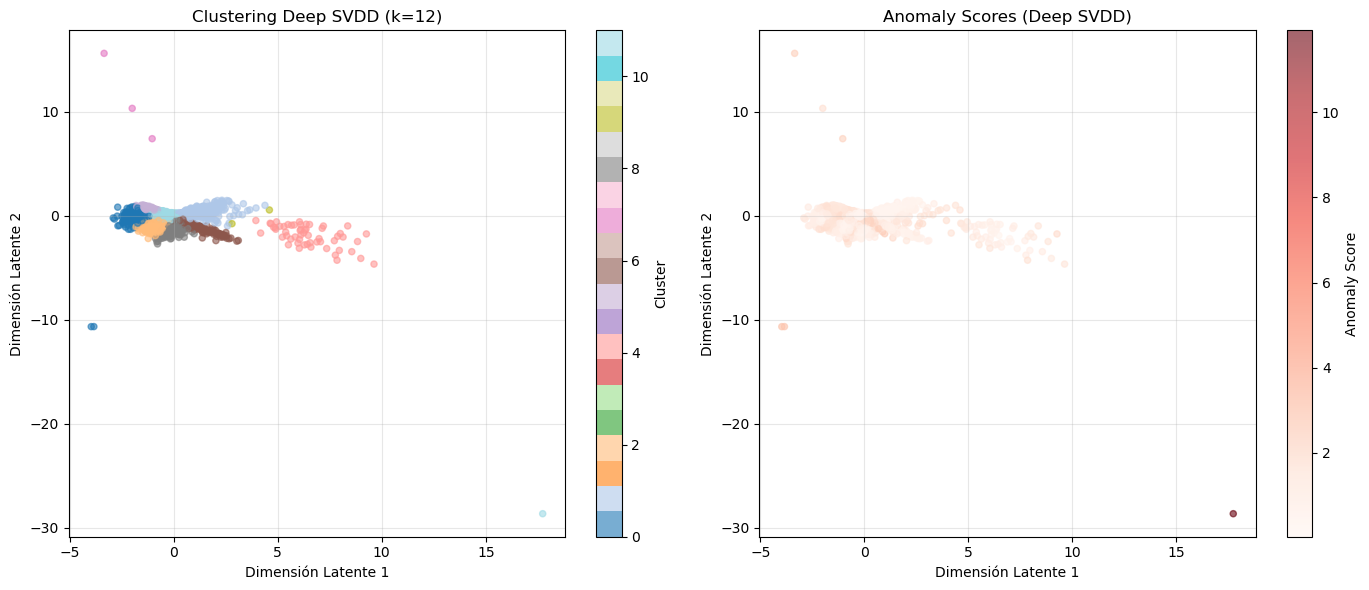

In [42]:
print("\n" + "="*80)
print("PARTE 3: MULTI-CLASS DEEP SVDD")
print("="*80)

class DeepSVDD(nn.Module):
    def __init__(self, input_dim, n_classes):
        super(DeepSVDD, self).__init__()
        self.n_classes = n_classes
        
        # Red para mapear al espacio de características
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        
        # Centros para cada clase (aprendibles)
        self.centers = nn.Parameter(torch.randn(n_classes, 16))
    
    def forward(self, x):
        features = self.network(x)
        return features
    
    def compute_distances(self, features):
        # Distancia de cada punto a cada centro
        distances = torch.cdist(features, self.centers)
        return distances

# Inicializar usando los clusters de GMM como pseudo-labels
print("\nInicializando Multi-Class Deep SVDD con clusters GMM...")

deep_svdd = DeepSVDD(input_dim=LATENT_DIM, n_classes=optimal_n_components)
deep_svdd = deep_svdd.to(device)

# Preparar datos
X_latent_tensor = torch.FloatTensor(latent_np)
y_gmm_tensor = torch.LongTensor(gmm_clusters)
dataset_svdd = TensorDataset(X_latent_tensor, y_gmm_tensor)
dataloader_svdd = DataLoader(dataset_svdd, batch_size=BATCH_SIZE, shuffle=True)

# Entrenamiento
optimizer_svdd = optim.Adam(deep_svdd.parameters(), lr=0.001)
EPOCHS_SVDD = 50

print(f"\nEntrenando Deep SVDD por {EPOCHS_SVDD} épocas...")
svdd_losses = []

for epoch in range(EPOCHS_SVDD):
    deep_svdd.train()
    epoch_loss = 0
    
    for batch_x, batch_y in dataloader_svdd:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        # Forward pass
        features = deep_svdd(batch_x)
        distances = deep_svdd.compute_distances(features)
        
        # Loss: distancia al centro de la clase asignada
        loss = torch.gather(distances, 1, batch_y.unsqueeze(1)).mean()
        
        # Regularización: penalizar centros muy cercanos
        center_distances = torch.cdist(deep_svdd.centers, deep_svdd.centers)
        reg_loss = torch.exp(-center_distances).mean()
        
        total_loss = loss + 0.1 * reg_loss
        
        # Backward pass
        optimizer_svdd.zero_grad()
        total_loss.backward()
        optimizer_svdd.step()
        
        epoch_loss += total_loss.item()
    
    avg_loss = epoch_loss / len(dataloader_svdd)
    svdd_losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Época [{epoch+1}/{EPOCHS_SVDD}], Loss: {avg_loss:.4f}")

print("\n¡Entrenamiento Deep SVDD completado!")

# Obtener asignaciones finales
deep_svdd.eval()
with torch.no_grad():
    X_latent_full = torch.FloatTensor(latent_np).to(device)
    svdd_features = deep_svdd(X_latent_full)
    svdd_distances = deep_svdd.compute_distances(svdd_features)
    svdd_clusters = torch.argmin(svdd_distances, dim=1).cpu().numpy()
    svdd_min_distances = torch.min(svdd_distances, dim=1)[0].cpu().numpy()

print(f"\nDistribución de clusters Deep SVDD:")
for i in range(optimal_n_components):
    count = np.sum(svdd_clusters == i)
    print(f"  Cluster {i}: {count} objetos ({count/len(svdd_clusters)*100:.1f}%)")

# Visualizar Deep SVDD
if LATENT_DIM == 2:
    plt.figure(figsize=(14, 6))
    
    # Clusters Deep SVDD
    plt.subplot(1, 2, 1)
    scatter = plt.scatter(latent_np[:, 0], latent_np[:, 1], 
                         c=svdd_clusters, cmap='tab20', alpha=0.6, s=20)
    
    # Plot centros aprendidos
    centers_np = deep_svdd.centers.detach().cpu().numpy()
    # Proyectar centros al espacio latente original (aproximación)
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel('Dimensión Latente 1')
    plt.ylabel('Dimensión Latente 2')
    plt.title(f'Clustering Deep SVDD (k={optimal_n_components})')
    plt.grid(alpha=0.3)
    
    # Anomaly scores (distancia mínima a centros)
    plt.subplot(1, 2, 2)
    scatter2 = plt.scatter(latent_np[:, 0], latent_np[:, 1], 
                          c=svdd_min_distances, cmap='Reds', alpha=0.6, s=20)
    plt.colorbar(scatter2, label='Anomaly Score')
    plt.xlabel('Dimensión Latente 1')
    plt.ylabel('Dimensión Latente 2')
    plt.title('Anomaly Scores (Deep SVDD)')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


PARTE 4: ANÁLISIS DE OUTLIERS

Outliers identificados (percentil 95):
  Total: 119 objetos (5.03%)
  Threshold de anomalía: 1.6574


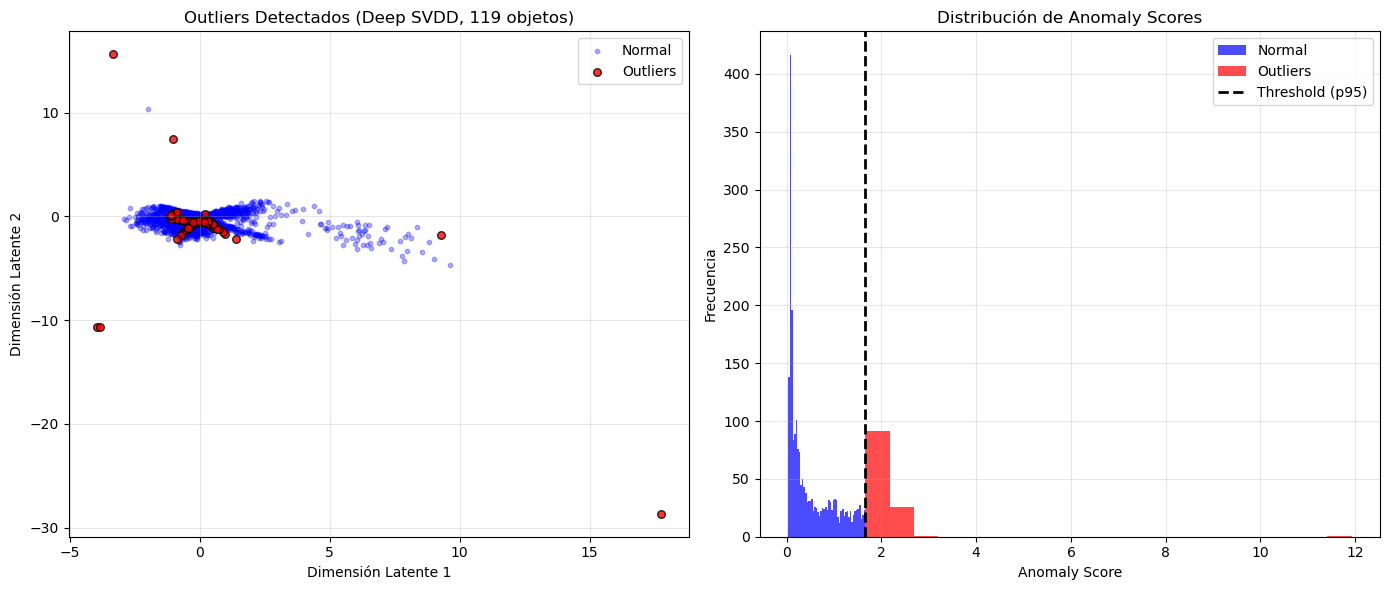

In [43]:
print("\n" + "="*80)
print("PARTE 4: ANÁLISIS DE OUTLIERS")
print("="*80)

# Identificar outliers usando Deep SVDD scores
threshold_percentile = 95
anomaly_threshold = np.percentile(svdd_min_distances, threshold_percentile)

outliers_mask = svdd_min_distances > anomaly_threshold
n_outliers = np.sum(outliers_mask)

print(f"\nOutliers identificados (percentil {threshold_percentile}):")
print(f"  Total: {n_outliers} objetos ({n_outliers/len(outliers_mask)*100:.2f}%)")
print(f"  Threshold de anomalía: {anomaly_threshold:.4f}")

# Visualizar outliers
if LATENT_DIM == 2:
    plt.figure(figsize=(14, 6))
    
    # Outliers en espacio latente
    plt.subplot(1, 2, 1)
    plt.scatter(latent_np[~outliers_mask, 0], latent_np[~outliers_mask, 1],
               c='blue', alpha=0.3, s=10, label='Normal')
    plt.scatter(latent_np[outliers_mask, 0], latent_np[outliers_mask, 1],
               c='red', alpha=0.8, s=30, label='Outliers', edgecolors='black')
    plt.xlabel('Dimensión Latente 1')
    plt.ylabel('Dimensión Latente 2')
    plt.title(f'Outliers Detectados (Deep SVDD, {n_outliers} objetos)')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Distribución de anomaly scores
    plt.subplot(1, 2, 2)
    plt.hist(svdd_min_distances[~outliers_mask], bins=50, alpha=0.7, 
            label='Normal', color='blue')
    plt.hist(svdd_min_distances[outliers_mask], bins=20, alpha=0.7,
            label='Outliers', color='red')
    plt.axvline(anomaly_threshold, color='black', linestyle='--', linewidth=2,
               label=f'Threshold (p{threshold_percentile})')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Anomaly Scores')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


PARTE 5: COMPARACIÓN Y ANÁLISIS DE CLUSTERS


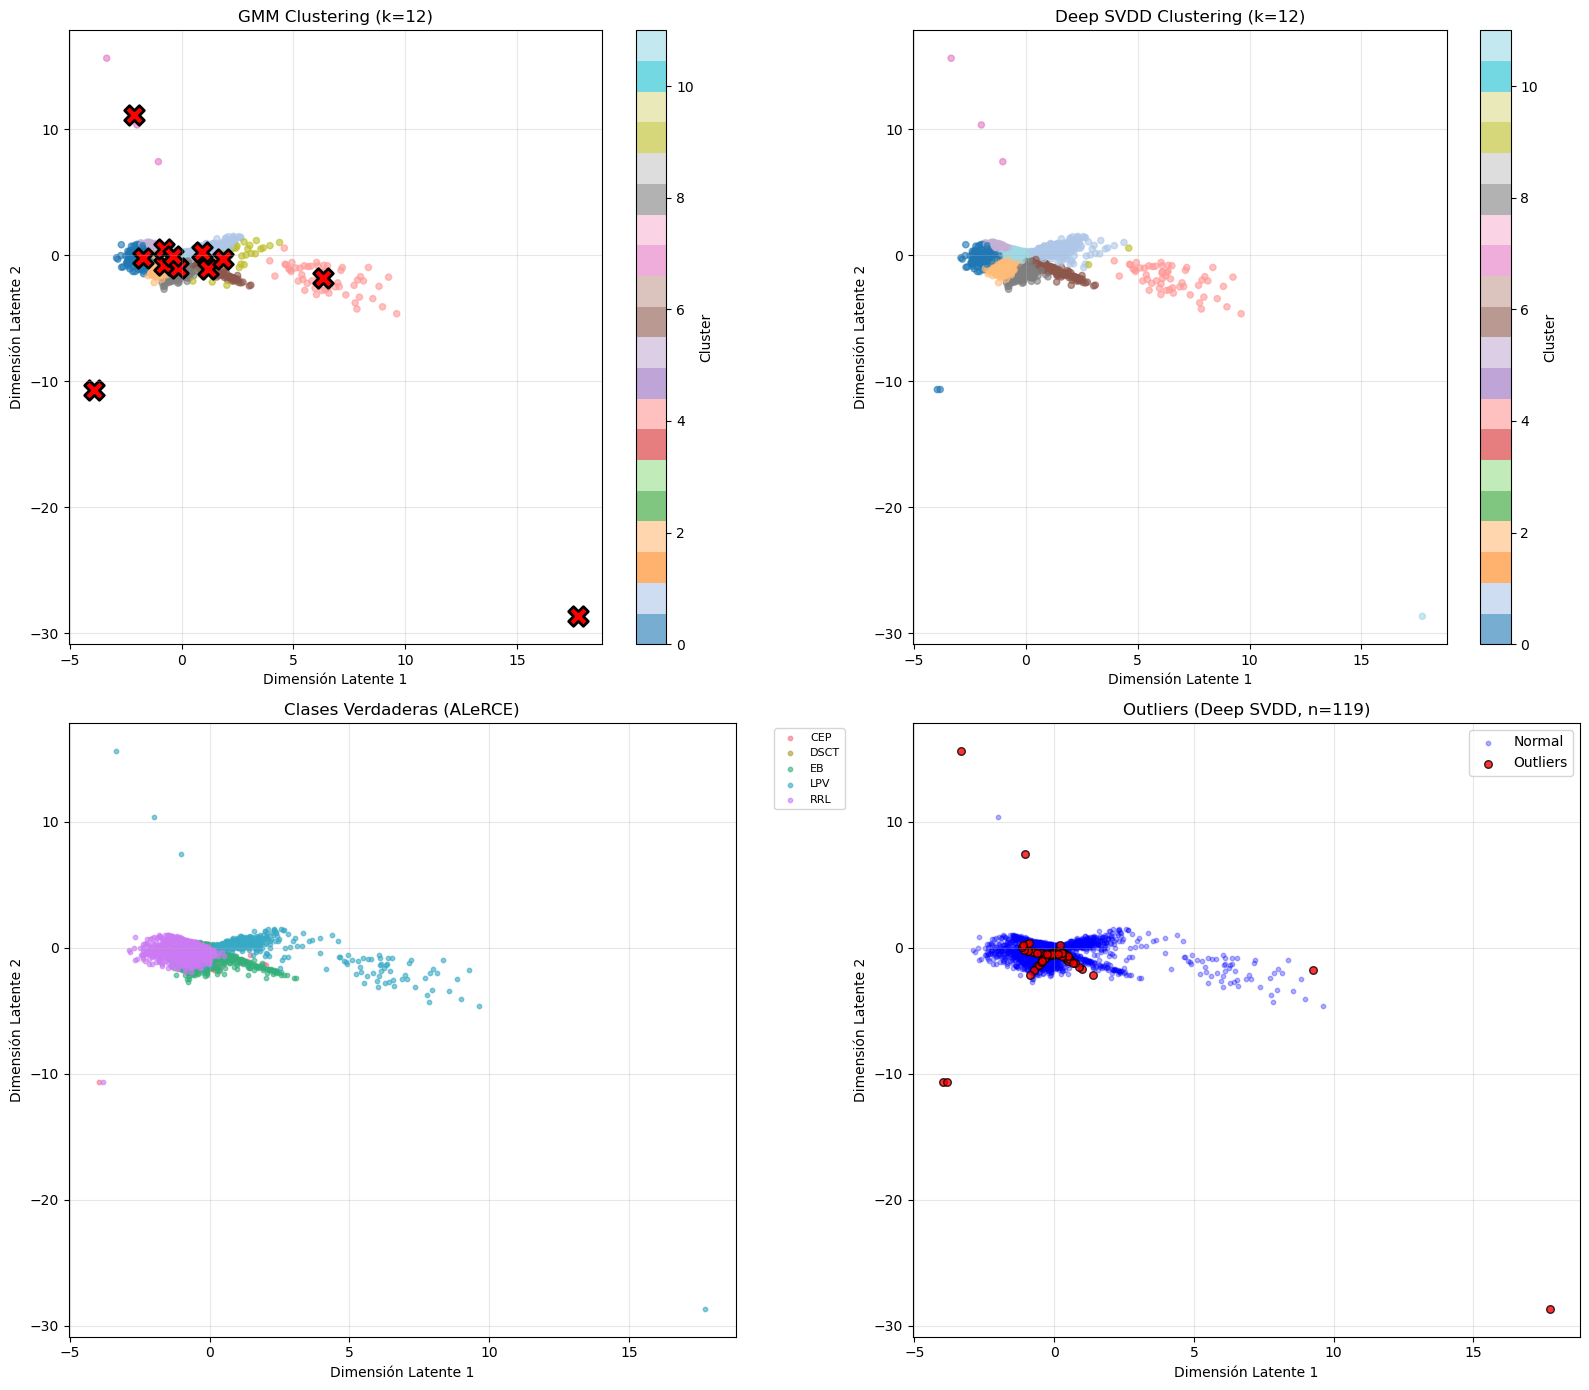


ESTADÍSTICAS POR CLUSTER (GMM)

Cluster 0:
  Tamaño: 156 objetos (6.6%)
  Clases más comunes:
    - RRL: 150 (96.2%)
    - EB: 3 (1.9%)
    - CEP: 2 (1.3%)
  Centro (promedio): [-1.838428   -0.20718354]
  Desviación estándar: [0.36888012 0.5081326 ]

Cluster 1:
  Tamaño: 296 objetos (12.5%)
  Clases más comunes:
    - LPV: 270 (91.2%)
    - EB: 21 (7.1%)
    - CEP: 4 (1.4%)
  Centro (promedio): [1.0369674 0.355904 ]
  Desviación estándar: [0.54604906 0.35870054]

Cluster 2:
  Tamaño: 435 objetos (18.4%)
  Clases más comunes:
    - RRL: 220 (50.6%)
    - EB: 169 (38.9%)
    - DSCT: 24 (5.5%)
  Centro (promedio): [-0.86039233 -0.8474663 ]
  Desviación estándar: [0.24885432 0.40427843]

Cluster 3:
  Tamaño: 1 objetos (0.0%)
  Clases más comunes:
    - LPV: 1 (100.0%)
  Centro (promedio): [ 17.731825 -28.6515  ]
  Desviación estándar: [0. 0.]

Cluster 4:
  Tamaño: 57 objetos (2.4%)
  Clases más comunes:
    - LPV: 57 (100.0%)
  Centro (promedio): [ 6.4216356 -1.8803233]
  Desviación están

In [44]:
print("\n" + "="*80)
print("PARTE 5: COMPARACIÓN Y ANÁLISIS DE CLUSTERS")
print("="*80)

# Comparar GMM vs Deep SVDD
if LATENT_DIM == 2:
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    
    # GMM Clusters
    ax1 = axes[0, 0]
    scatter1 = ax1.scatter(latent_np[:, 0], latent_np[:, 1], 
                          c=gmm_clusters, cmap='tab20', alpha=0.6, s=20)
    ax1.scatter(gmm_final.means_[:, 0], gmm_final.means_[:, 1],
               c='red', marker='X', s=200, edgecolors='black', linewidths=2)
    ax1.set_xlabel('Dimensión Latente 1')
    ax1.set_ylabel('Dimensión Latente 2')
    ax1.set_title(f'GMM Clustering (k={optimal_n_components})')
    ax1.grid(alpha=0.3)
    plt.colorbar(scatter1, ax=ax1, label='Cluster')
    
    # Deep SVDD Clusters
    ax2 = axes[0, 1]
    scatter2 = ax2.scatter(latent_np[:, 0], latent_np[:, 1], 
                          c=svdd_clusters, cmap='tab20', alpha=0.6, s=20)
    ax2.set_xlabel('Dimensión Latente 1')
    ax2.set_ylabel('Dimensión Latente 2')
    ax2.set_title(f'Deep SVDD Clustering (k={optimal_n_components})')
    ax2.grid(alpha=0.3)
    plt.colorbar(scatter2, ax=ax2, label='Cluster')
    
    # Clases reales (si existen)
    if labels is not None:
        ax3 = axes[1, 0]
        unique_labels_plot = np.unique(labels)
        colors = sns.color_palette("husl", len(unique_labels_plot))
        for label, color in zip(unique_labels_plot, colors):
            mask = labels == label
            ax3.scatter(latent_np[mask, 0], latent_np[mask, 1],
                       c=[color], label=label, alpha=0.6, s=10)
        ax3.set_xlabel('Dimensión Latente 1')
        ax3.set_ylabel('Dimensión Latente 2')
        ax3.set_title('Clases Verdaderas (ALeRCE)')
        ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        ax3.grid(alpha=0.3)
    
    # Outliers
    ax4 = axes[1, 1]
    ax4.scatter(latent_np[~outliers_mask, 0], latent_np[~outliers_mask, 1],
               c='blue', alpha=0.3, s=10, label='Normal')
    ax4.scatter(latent_np[outliers_mask, 0], latent_np[outliers_mask, 1],
               c='red', alpha=0.8, s=30, label='Outliers', edgecolors='black')
    ax4.set_xlabel('Dimensión Latente 1')
    ax4.set_ylabel('Dimensión Latente 2')
    ax4.set_title(f'Outliers (Deep SVDD, n={n_outliers})')
    ax4.legend()
    ax4.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Estadísticas por cluster
print("\n" + "="*80)
print("ESTADÍSTICAS POR CLUSTER (GMM)")
print("="*80)

for cluster_id in range(optimal_n_components):
    mask = gmm_clusters == cluster_id
    cluster_size = np.sum(mask)
    
    print(f"\nCluster {cluster_id}:")
    print(f"  Tamaño: {cluster_size} objetos ({cluster_size/len(gmm_clusters)*100:.1f}%)")
    
    # Distribución de clases reales en este cluster
    if labels is not None:
        cluster_labels = labels[mask]
        label_counts = pd.Series(cluster_labels).value_counts()
        print(f"  Clases más comunes:")
        for label, count in label_counts.head(3).items():
            print(f"    - {label}: {count} ({count/cluster_size*100:.1f}%)")
    
    # Estadísticas del espacio latente
    cluster_points = latent_np[mask]
    print(f"  Centro (promedio): {cluster_points.mean(axis=0)}")
    print(f"  Desviación estándar: {cluster_points.std(axis=0)}")

# Guardar resultados
print("\n" + "="*80)
print("GUARDANDO RESULTADOS")
print("="*80)

results_df = pd.DataFrame({
    'latent_dim1': latent_np[:, 0],
    'latent_dim2': latent_np[:, 1] if LATENT_DIM >= 2 else 0,
    'gmm_cluster': gmm_clusters,
    'svdd_cluster': svdd_clusters,
    'anomaly_score': svdd_min_distances,
    'is_outlier': outliers_mask,
    'true_class': labels if labels is not None else np.nan
})

if LATENT_DIM >= 3:
    for i in range(2, min(LATENT_DIM, 5)):
        results_df[f'latent_dim{i+1}'] = latent_np[:, i]

print("\nResultados guardados en DataFrame 'results_df'")
print(f"Shape: {results_df.shape}")
print(f"\nPrimeras filas:")
print(results_df.head())